In [ ]:
!pip install sympy
!pip install networkx

# Load Liberaties

In [1]:
import re
import sympy as sp
import networkx as nx
import numpy as np
import pandas as pd
from itertools import permutations
from collections import defaultdict

import io
import contextlib
from tqdm import tqdm

from matplotlib import pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.gridspec import GridSpec

from io import BytesIO
from PIL import Image

# General Settings

In [2]:
# Phi = sp.Rational(3,2)
Phi = sp.symbols('phi')
Delta = sp.Integer(1)
Beta = sp.Integer(1)

# Required Functions

In [3]:
def get_all_possible_edges(num_nodes):
    """
    Generates all possible undirected edges for a given number of nodes.
    For N nodes, there are N * (N - 1) / 2 possible edges.
    """
    edges = []
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            edges.append((i, j))
    return edges

In [4]:
def adjacency_matrix_to_tuple(adj_matrix):
    """
    Converts a numpy adjacency matrix to a hashable tuple of tuples.
    This is necessary to store matrices in a set for uniqueness checks.
    """
    return tuple(tuple(row) for row in adj_matrix)

In [5]:
def get_canonical_form_and_permutation(matrix, num_nodes, h_nodes, l_nodes):
    """
    Computes the canonical form (lexicographically smallest adjacency matrix)
    of a graph and the permutation that achieved it, given its adjacency matrix
    and the H/L node assignments.

    Args:
        matrix (numpy.ndarray): The adjacency matrix of the graph.
        num_nodes (int): Total number of nodes.
        h_nodes (list): List of original indices designated as 'H' nodes.
        l_nodes (list): List of original indices designated as 'L' nodes.

    Returns:
        tuple: (canonical_matrix_tuple, permutation_mapping)
               - canonical_matrix_tuple: The hashable canonical adjacency matrix.
               - permutation_mapping: A list `P` where `P[original_idx]` is the
                                      new canonical index of `original_idx`.
    """
    canonical_form = None
    best_permutation_map = None # Stores the permutation that maps original -> canonical

    h_permutations = list(permutations(h_nodes))
    l_permutations = list(permutations(l_nodes))

    for p_h in h_permutations:
        for p_l in l_permutations:
            current_permutation_map = [0] * num_nodes # Maps original_idx -> canonical_idx
            
            for i, h_node_original_idx in enumerate(h_nodes):
                current_permutation_map[h_node_original_idx] = p_h[i]
            for i, l_node_original_idx in enumerate(l_nodes):
                current_permutation_map[l_node_original_idx] = p_l[i]

            permuted_adj_matrix = matrix[current_permutation_map, :][:, current_permutation_map]
            current_canonical_tuple = adjacency_matrix_to_tuple(permuted_adj_matrix)

            if canonical_form is None or current_canonical_tuple < canonical_form:
                canonical_form = current_canonical_tuple
                best_permutation_map = current_permutation_map
                
    return canonical_form, best_permutation_map


In [6]:
def generate_unique_graphs_with_names(n, n_h):
    """
    Generates unique undirected graphs for 'n' nodes with 'n_h' H-type nodes
    and 'n-n_h' L-type nodes, assigning a unique name to each.

    Args:
        n (int): The total number of nodes.
        n_h (int): The number of 'H' type nodes.

    Returns:
        list: A list of dictionaries. Each dictionary contains:
              - 'name' (str): The unique name of the graph.
              - 'matrix' (numpy.ndarray): The adjacency matrix of the graph.
    """
    n_l = n - n_h
    h_nodes = list(range(n_h))
    l_nodes = list(range(n_h, n))
    all_edges = get_all_possible_edges(n)
    seen_canonical_forms = set()
    unique_graph_data = []
    edge_alphabet_counters = {}
    for i in range(2 ** len(all_edges)):
        adj_matrix = np.zeros((n, n), dtype=int)
        for j in range(len(all_edges)):
            if (i >> j) & 1:
                u, v = all_edges[j]
                adj_matrix[u, v] = 1
                adj_matrix[v, u] = 1
        canonical_form, _ = get_canonical_form_and_permutation(adj_matrix, n, h_nodes, l_nodes)
        if canonical_form not in seen_canonical_forms:
            seen_canonical_forms.add(canonical_form)
            num_edges = int(np.sum(np.array(canonical_form)) / 2)
            current_alphabet_idx = edge_alphabet_counters.get(num_edges, 0)
            alphabet_char = chr(ord('A') + current_alphabet_idx)
            edge_alphabet_counters[num_edges] = current_alphabet_idx + 1
            graph_name = f"E{num_edges}{alphabet_char} [{n_h}H{n_l}L]"
            unique_graph_data.append({'name': graph_name, 'matrix': np.array(canonical_form)})
    unique_graph_data.sort(key=lambda x: (int(x['name'][1]), x['name']))
    return unique_graph_data

In [7]:
def generate_transition_graph(n, n_h):
    """
    Creates a graph where nodes are unique network structures
    and edges represent single-link additions or removals.

    Args:
        n (int): The total number of nodes.
        n_h (int): The number of 'H' type nodes.

    Returns:
        dict: A dictionary where keys are graph names (e.g., "E1A [2H2L]").
              Each value is another dictionary with two sets:
              {'add': set(names_of_graphs_reachable_by_adding_one_edge),
               'remove': set(names_of_graphs_reachable_by_removing_one_edge)}.
    """
    
    n_l = n - n_h
    h_nodes = list(range(n_h)) # H nodes are the first n_h nodes
    l_nodes = list(range(n_h, n)) # L nodes are the remaining n_l nodes

    # 1. Generate all unique base graphs for the given configuration
    base_unique_graphs = generate_unique_graphs_with_names(n, n_h)

    # 2. Create a lookup map from canonical form (tuple) to graph name
    canonical_to_name_map = {
        adjacency_matrix_to_tuple(g['matrix']): g['name']
        for g in base_unique_graphs
    }

    # 3. Initialize the transition graph dictionary
    # Each graph's name will be a key, and its value will contain 'add' and 'remove' sets
    transition_graph = {
        g['name']: {'add': set(), 'remove': set()}
        for g in base_unique_graphs
    }

    # Get all possible edges for an n-node graph
    all_possible_edges = get_all_possible_edges(n)

    # 4. Iterate through each unique graph to find its transitions
    for current_graph_data in base_unique_graphs:
        current_name = current_graph_data['name']
        current_matrix = current_graph_data['matrix']

        # 5. Simulate adding/removing each possible edge
        for u, v in all_possible_edges:
            # Create a copy of the current matrix to modify
            temp_matrix = np.copy(current_matrix)

            # Check if the edge (u,v) exists in the current graph
            if current_matrix[u, v] == 1:
                # Edge exists, simulate removal
                temp_matrix[u, v] = 0
                temp_matrix[v, u] = 0
                transition_type = 'remove'
            else:
                # Edge does not exist, simulate addition
                temp_matrix[u, v] = 1
                temp_matrix[v, u] = 1
                transition_type = 'add'
            
            # 6. Find the canonical form of the modified graph
            modified_canonical_form, _ = get_canonical_form_and_permutation(temp_matrix, n, h_nodes, l_nodes)
            
            # 7. Look up the name of the modified graph in our map
            # This ensures we get the *canonical* name for the resulting structure
            modified_graph_name = canonical_to_name_map.get(modified_canonical_form)

            # 8. If we found a valid modified graph name, add it to the transition graph
            # We add it to the set, so duplicates are automatically handled.
            if modified_graph_name: # Ensure it's a valid graph name
                transition_graph[current_name][transition_type].add(modified_graph_name)

    return transition_graph

In [8]:
def generate_detailed_transition_map(n, n_h):
    """
    Generates a detailed transition map for unique graphs with 'n' nodes and 'n_h' H-type nodes.
    Each transition is represented with details about the nodes involved and the permutations used.
    Args:
        n (int): Total number of nodes in the graph.
        n_h (int): Number of 'H' type nodes.

    Returns:
        dict: A dictionary where keys are graph names (e.g., "E1A [2H2L]").
                Each value is another dictionary with two lists:
                {'add': list_of_details_for_additions,
                 'remove': list_of_details_for_removals}.
    """
    h_nodes = list(range(n_h))
    l_nodes = list(range(n_h, n))

    base_unique_graphs_list = generate_unique_graphs_with_names(n, n_h)
    
    canonical_details_map = {}
    for graph_info in base_unique_graphs_list:
        canonical_tuple, perm_original_to_canonical = get_canonical_form_and_permutation(
            graph_info['matrix'], n, h_nodes, l_nodes
        )
        graph_info['permutation_to_canonical'] = perm_original_to_canonical
        canonical_details_map[canonical_tuple] = graph_info
    
    detailed_transition_map = {}
    best_transition_maps = {} 

    all_possible_edges = get_all_possible_edges(n)

    for current_graph_data in base_unique_graphs_list:
        current_name = current_graph_data['name']
        current_matrix = current_graph_data['matrix']
        current_permutation_map = current_graph_data['permutation_to_canonical']

        for u, v in all_possible_edges:
            temp_matrix = np.copy(current_matrix)
            
            transition_type = ''
            if current_matrix[u, v] == 1:
                temp_matrix[u, v] = 0
                temp_matrix[v, u] = 0
                transition_type = 'remove'
            else:
                temp_matrix[u, v] = 1
                temp_matrix[v, u] = 1
                transition_type = 'add'
            
            modified_canonical_form, perm_original_to_target_canonical = get_canonical_form_and_permutation(
                temp_matrix, n, h_nodes, l_nodes
            )
            
            modified_graph_info = canonical_details_map.get(modified_canonical_form)

            if modified_graph_info:
                target_name = modified_graph_info['name']
                
                transition_key = (current_name, target_name, transition_type)

                target_canonical_u = perm_original_to_target_canonical.index(u)
                target_canonical_v = perm_original_to_target_canonical.index(v)

                involved_nodes_tuple = tuple(sorted(((u, target_canonical_u), (v, target_canonical_v))))

                current_transition_detail = {
                    'target_name': target_name,
                    'nodes_involved_map': involved_nodes_tuple,
                    'source_permutation_map': current_permutation_map,
                    'target_permutation_map': perm_original_to_target_canonical
                }

                if transition_key not in best_transition_maps or \
                   involved_nodes_tuple < best_transition_maps[transition_key]['nodes_involved_map']:
                    best_transition_maps[transition_key] = current_transition_detail
    
    for (source_name, target_name, transition_type), details in best_transition_maps.items():
        if source_name not in detailed_transition_map:
            detailed_transition_map[source_name] = {'add': [], 'remove': []}
        detailed_transition_map[source_name][transition_type].append(details)

    for source_name in detailed_transition_map:
        for t_type in ['add', 'remove']:
            detailed_transition_map[source_name][t_type].sort(key=lambda x: x['target_name'])

    return detailed_transition_map

In [9]:
def render_graph(adj_matrix, n_h, layout='circular', figsize=(1.0, 1.0), title=''):
    """
    Render a graph from an adjacency matrix. Nodes 0 to n_h-1 are type 'H', others are 'L'.
    
    Args:
        adj_matrix (np.ndarray): Binary symmetric adjacency matrix.
        n_h (int): Number of H-type nodes.
        layout (str): 'circular', 'spring', or 'kamada_kawai'.
        figsize (tuple): Size of the figure in inches.

    Returns:
        PIL.Image: Rendered graph image.
    """
    n = adj_matrix.shape[0]
    G = nx.Graph()

    # Add nodes with type attributes
    for i in range(n):
        node_type = 'H' if i < n_h else 'L'
        G.add_node(i, type=node_type)

    # Add edges based on upper triangle of adjacency matrix
    for i in range(n):
        for j in range(i+1, n):
            if adj_matrix[i, j]:
                G.add_edge(i, j)

    # Choose layout
    if layout == 'circular':
        pos = nx.circular_layout(G)
    elif layout == 'spring':
        pos = nx.spring_layout(G, seed=42)
    elif layout == 'kamada_kawai':
        pos = nx.kamada_kawai_layout(G)
    else:
        raise ValueError("Invalid layout")

    # Start plotting
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis('off')

    # Node colors and labels
    node_colors = ['darkgray' if G.nodes[i]['type'] == 'H' else 'white' for i in G.nodes()]
    labels = {i: G.nodes[i]['type'] for i in G.nodes()}

    nx.draw_networkx_edges(G, pos, ax=ax, width=1)
    nx.draw_networkx_nodes(G, pos, ax=ax, node_color=node_colors, edgecolors='black', node_size=150)
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, font_color='black')

    scale = 1.8
    plt.ylim(-scale, scale)
    plt.xlim(-scale, scale)
    plt.tight_layout()

    # Plot a circle around the graph
    circle = patches.Circle((0, 0), scale - 0.05, color='none', ec='black', lw=1.5)
    ax.add_patch(circle)
    if title:
        plt.title(title, fontsize=10)

    # Save to buffer and return image
    buf = BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0.02)
    plt.close(fig)
    buf.seek(0)
    return Image.open(buf)

In [10]:
def visualize_transition_graph_with_graph_images(n, n_h, title="Transition Graph"):
    """
    Visualizes the transition graph using graph images instead of node labels.

    Args:
        transition_data (dict): Node transitions with 'add' and 'remove' edges.
        adj_matrices (dict): Mapping of node names to adjacency matrices.
        n_h (int): Number of H-type nodes in each adjacency matrix.
        title (str): Plot title.
    """
    G = nx.DiGraph()
    
    transition_data = generate_transition_graph(n, n_h)
    adj_matrices = dict()
    for graph_data in generate_unique_graphs_with_names(n, n_h):
        adj_matrices[graph_data['name']] = graph_data['matrix']
    
    # Add nodes
    for node_name in transition_data.keys():
        G.add_node(node_name)

    edge_colors = []
    
    # Add edges and assign colors
    for source_name, transitions in transition_data.items():
        # for target_name in transitions['add']:
        #     G.add_edge(source_name, target_name)
        #     edge_colors.append('green')
        for target_name in transitions['remove']:
            G.add_edge(source_name, target_name)
            edge_colors.append('red')


    # --- Custom Layout: Stack vertically by Ei level ---
    node_groups = defaultdict(list)
    for node in G.nodes():
        match = re.match(r"E(\d+)", node)
        if match:
            group_index = int(match.group(1))
            node_groups[group_index].append(node)

    pos = {}
    x_spacing = 3
    y_spacing = 1
    for i, (group_index, nodes) in enumerate(sorted(node_groups.items())):
        num_nodes = len(nodes)
        y_offset = (num_nodes - 1) * y_spacing / 2
        for j, node in enumerate(sorted(nodes)):
            pos[node] = (i * x_spacing, -j * y_spacing + y_offset)

    # --- Node Images ---
    node_images = {name: render_graph(adj_matrices[name], n_h, title=name) for name in G.nodes()}

    # --- Plotting ---
    spacing_x = 2.5
    spacing_y = 1.5
    fig_width = max(node_groups.keys()) * spacing_x + 2  # Width based on the last group index
    fig_height = max(len(nodes) for nodes in node_groups.values()) * spacing_y + 2  # Height based on the tallest group

    _, ax = plt.subplots(figsize=(fig_width, fig_height))
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=1.0, alpha=0.6, arrows=False, ax=ax)

    for node in G.nodes():
        image = node_images[node]
        im = OffsetImage(image, zoom=1)
        ab = AnnotationBbox(im, pos[node], frameon=False)
        ax.add_artist(ab)

    plt.title(title, size=20)
    plt.axis('off')
    return plt.tight_layout()

In [11]:
# Function to extract and convert LaTeX fractions to float
def latex_to_float(latex_str):
    match = re.search(r'\\phi\s*=\s*\\frac\{(\d+)\}\{(\d+)\}', latex_str)
    if match:
        numerator = int(match.group(1))
        denominator = int(match.group(2))
        return numerator / denominator
    match = re.search(r'\\phi\s*=\s*(\d+)', latex_str)
    if match:
        return float(match.group(1))
    return latex_str  # fallback

In [ ]:
# Parse stability domain strings
def parse_interval(entry):
    if '\\emptyset' in entry:
        return (0.0, 0.0)
    match = re.search(r'\[\s*([\d.]+)\s*,\s*([\d.]+)\s*$$', entry.replace(r'\left', '').replace(r'\right', ''))
    if match:
        return float(match.group(1)), float(match.group(2))
    return (0.0, 0.0)

In [13]:
def draw_grid_stability_plot(
        file_path, n, n_h, nrow, ncol, save_path1 = '', save_path2='', gts=12,
        linewidth=1.0
        ):
    df = pd.read_csv(file_path)
    network_names = df["Network"].tolist()
    phi_cols = df.columns[1:]
    phi_values = [latex_to_float(col) for col in phi_cols]

    # Parse the stability domains for 3H1L
    all_parsed_domains = []
    for i in range(len(df)):
        raw_row = df.iloc[i, 1:]
        parsed = [parse_interval(entry) for entry in raw_row]
        all_parsed_domains.append(parsed)

    # Generate graph mappings for 3H1L (3 H nodes, 1 L node)
    unique_graphs = generate_unique_graphs_with_names(n=n, n_h=n_h)
    name_to_graph = {g['name']: g['matrix'] for g in unique_graphs}
    name_to_image = {name: render_graph(mat, n_h=n_h) for name, mat in name_to_graph.items()}

    # --- Grid plot ---
    fig, axs = plt.subplots(nrow, ncol, figsize=(ncol * 3.2, nrow * 3), sharex=True, sharey=True)
    axs = axs.flatten()
    cmap_grid = cm.get_cmap('tab20', len(network_names))

    for idx, (name, domains) in enumerate(zip(network_names, all_parsed_domains)):
        phi_vals_filtered = []
        lowers_filtered = []
        uppers_filtered = []
        stability_started = False

        for phi, (lb, ub) in zip(phi_values, domains):
            if lb != 0.0 or ub != 0.0:
                stability_started = True
            if stability_started:
                phi_vals_filtered.append(phi)
                lowers_filtered.append(lb)
                uppers_filtered.append(ub)

        ax = axs[idx]
        color = cmap_grid(idx)
        if phi_vals_filtered:
            ax.fill_between(phi_vals_filtered, lowers_filtered, uppers_filtered, color=color, alpha=0.6)
            ax.plot(phi_vals_filtered, lowers_filtered, 'k--', linewidth=linewidth)
            ax.plot(phi_vals_filtered, uppers_filtered, 'k--', linewidth=linewidth)
        ax.set_title(name, fontsize=gts)
        ax.set_xlim(min(phi_values), max(phi_values))
        ax.set_ylim(0, 1)
        ax.grid(True, linewidth=0.3)

        if name in name_to_image:
            inset_ax = ax.inset_axes([0.70, 0.65, 0.3, 0.3])
            inset_ax.imshow(name_to_image[name])
            inset_ax.axis("off")

    for j in range(len(network_names), len(axs)):
        fig.delaxes(axs[j])

    # fig.suptitle('Stability Domain of All Networks (3H1L)', fontsize=18)
    fig.text(0.5, 0.04, r'$\phi$', ha='center', fontsize=18)
    fig.text(0.04, 0.5, r'$\theta$', va='center', rotation='vertical', fontsize=18)
    plt.tight_layout(rect=[0.04, 0.04, 1, 0.95])

    if save_path1:
        plt.savefig(save_path1, dpi=500, bbox_inches='tight')
    else:
        plt.show()



    # Identify the stable networks (those with any non-zero domain)
    stable_names = []
    stable_domains = []

    for name, domains in zip(network_names, all_parsed_domains):
        if any(lb != 0.0 or ub != 0.0 for lb, ub in domains):
            stable_names.append(name)
            stable_domains.append(domains)

    # Create combined plot for stable networks in 3H1L
    plt.figure(figsize=(8, 5))
    color_map = cm.get_cmap('tab10', max(10, len(stable_names)))

    for idx, (name, domains) in enumerate(zip(stable_names, stable_domains)):
        color = color_map(idx)
        phi_vals_filtered = []
        lowers_filtered = []
        uppers_filtered = []
        stability_started = False
        for phi, (lb, ub) in zip(phi_values, domains):
            if lb != 0.0 or ub != 0.0:
                stability_started = True
            if stability_started:
                phi_vals_filtered.append(phi)
                lowers_filtered.append(lb)
                uppers_filtered.append(ub)
        if phi_vals_filtered:
            plt.fill_between(phi_vals_filtered, lowers_filtered, uppers_filtered, alpha=0.4, label=name, color=color)
            plt.plot(phi_vals_filtered, lowers_filtered, linestyle='--', color=color, linewidth=linewidth)
            plt.plot(phi_vals_filtered, uppers_filtered, linestyle='--', color=color, linewidth=1)

    # plt.title("Stability Domain of Stable Networks in 3H1L", fontsize=16)
    plt.xlabel(r'$\phi$', fontsize=12)
    plt.ylabel(r'$\theta$', fontsize=12)
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.tight_layout()
    if save_path2:
        plt.savefig(save_path2, dpi=500, bbox_inches='tight')
    else:
        plt.show()

In [14]:
def plot_expression_domain(
        expressions, 
        theta_min=0, 
        theta_max=1, 
        phi_min=0.01, 
        phi_max=5, 
        num_points=200, 
        epsilon=1e-9, 
        title='', 
        ax=None, 
        alpha=1, 
        color='Blues'
    ):
    """
    Plots the domain (theta, phi) where all given SymPy expressions are greater than zero.

    Args:
        expressions (list): A list of SymPy expressions. Each expression should involve
                            the symbols 'theta' and 'phi'.
        theta_min (float): The minimum value for theta.
        theta_max (float): The maximum value for theta.
        phi_min (float): The minimum value for phi (should be > 0 if expressions are sensitive to phi=0).
        phi_max (float): The maximum value for phi to plot.
        num_points (int): The number of points to use for the grid along each axis.
                          Higher values increase resolution but also computation time.
        epsilon (float): A small tolerance value used to check if an expression is
                         strictly greater than zero (expr > epsilon). This helps
                         with floating-point inaccuracies.
    """
    # Define the symbols within the function scope
    theta, phi = sp.symbols('theta phi')

    # 1. Create a grid of points for theta and phi
    theta_vals = np.linspace(theta_min, theta_max, num_points)
    phi_vals = np.linspace(phi_min, phi_max, num_points)
    Theta, Phi = np.meshgrid(theta_vals, phi_vals)

    # 2. Lambdify the expressions for efficient numerical evaluation
    # This converts SymPy expressions into functions that can operate on NumPy arrays.
    lambdified_expressions = [sp.lambdify((theta, phi), expr, 'numpy') for expr in expressions]

    # 3. Evaluate all expressions across the grid
    # This will result in a list of 2D NumPy arrays, where each array
    # corresponds to the evaluated values of one expression over the grid.
    evaluated_results = [f(Theta, Phi) for f in lambdified_expressions]

    # 4. Check the condition: all expressions must be greater than zero
    # Initialize a boolean array, assuming all points are valid initially.
    # It will be set to False for any point where at least one expression is not > epsilon.
    all_greater_than_zero = np.full(Theta.shape, True, dtype=bool)

    # Iterate through each evaluated expression's result array
    for result_array in (evaluated_results):
        # Update the boolean array: a point remains True only if it was already True
        # AND the current expression is greater than epsilon.
        all_greater_than_zero &= (result_array > epsilon)

    # 5. Plot the resulting domain
    if ax is None:
        plt.figure(figsize=(6, 5))
        ax = plt.gca()  # Get the current axes if not provided

    # Use pcolormesh to visualize the boolean array.
    # 'cmap='Blues'' will color the 'True' regions (where all expressions are > 0) in blue.
    # 'shading='auto'' automatically determines the best shading method.
    ax.pcolormesh(Theta, Phi, all_greater_than_zero, cmap=color, shading='auto', alpha=alpha)

    ax.set_xlabel(r'$\theta$')  # Using LaTeX for theta symbol
    ax.set_ylabel(r'$\phi$')    # Using LaTeX for phi symbol
    ax.set_title(title if title else 'Domain of Valid (theta, phi) Pairs')
    ax.set_xlim(theta_min, theta_max)
    ax.set_ylim(phi_min, phi_max)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_aspect('auto')  # Adjust aspect ratio for better visualization

    return ax

# Plot Transition Graphs

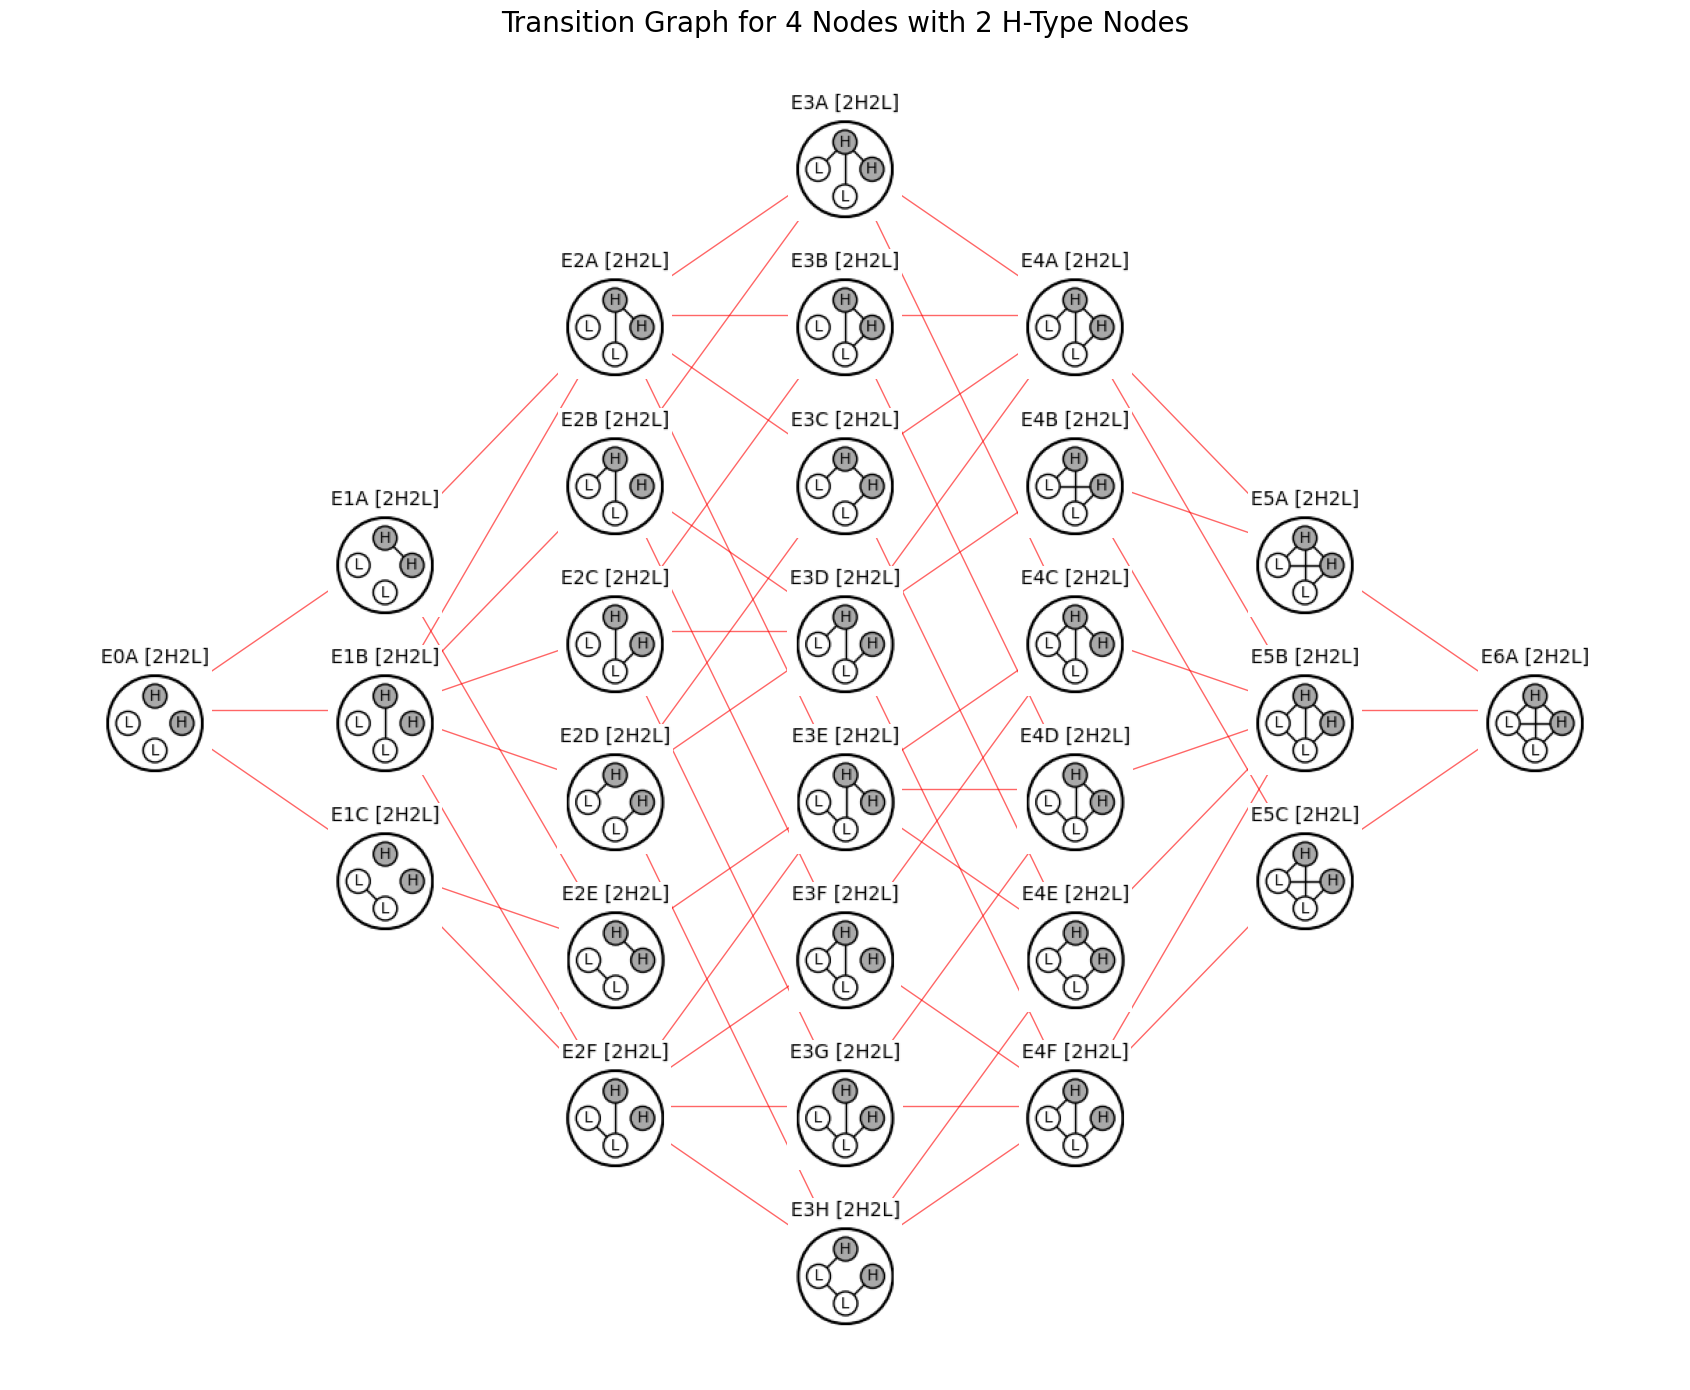

In [19]:
n, n_h = 4, 2

visualize_transition_graph_with_graph_images(
    n, n_h,
    title=f"Transition Graph for {n} Nodes with {n_h} H-Type Nodes"
)
plt.tight_layout()
plt.show()

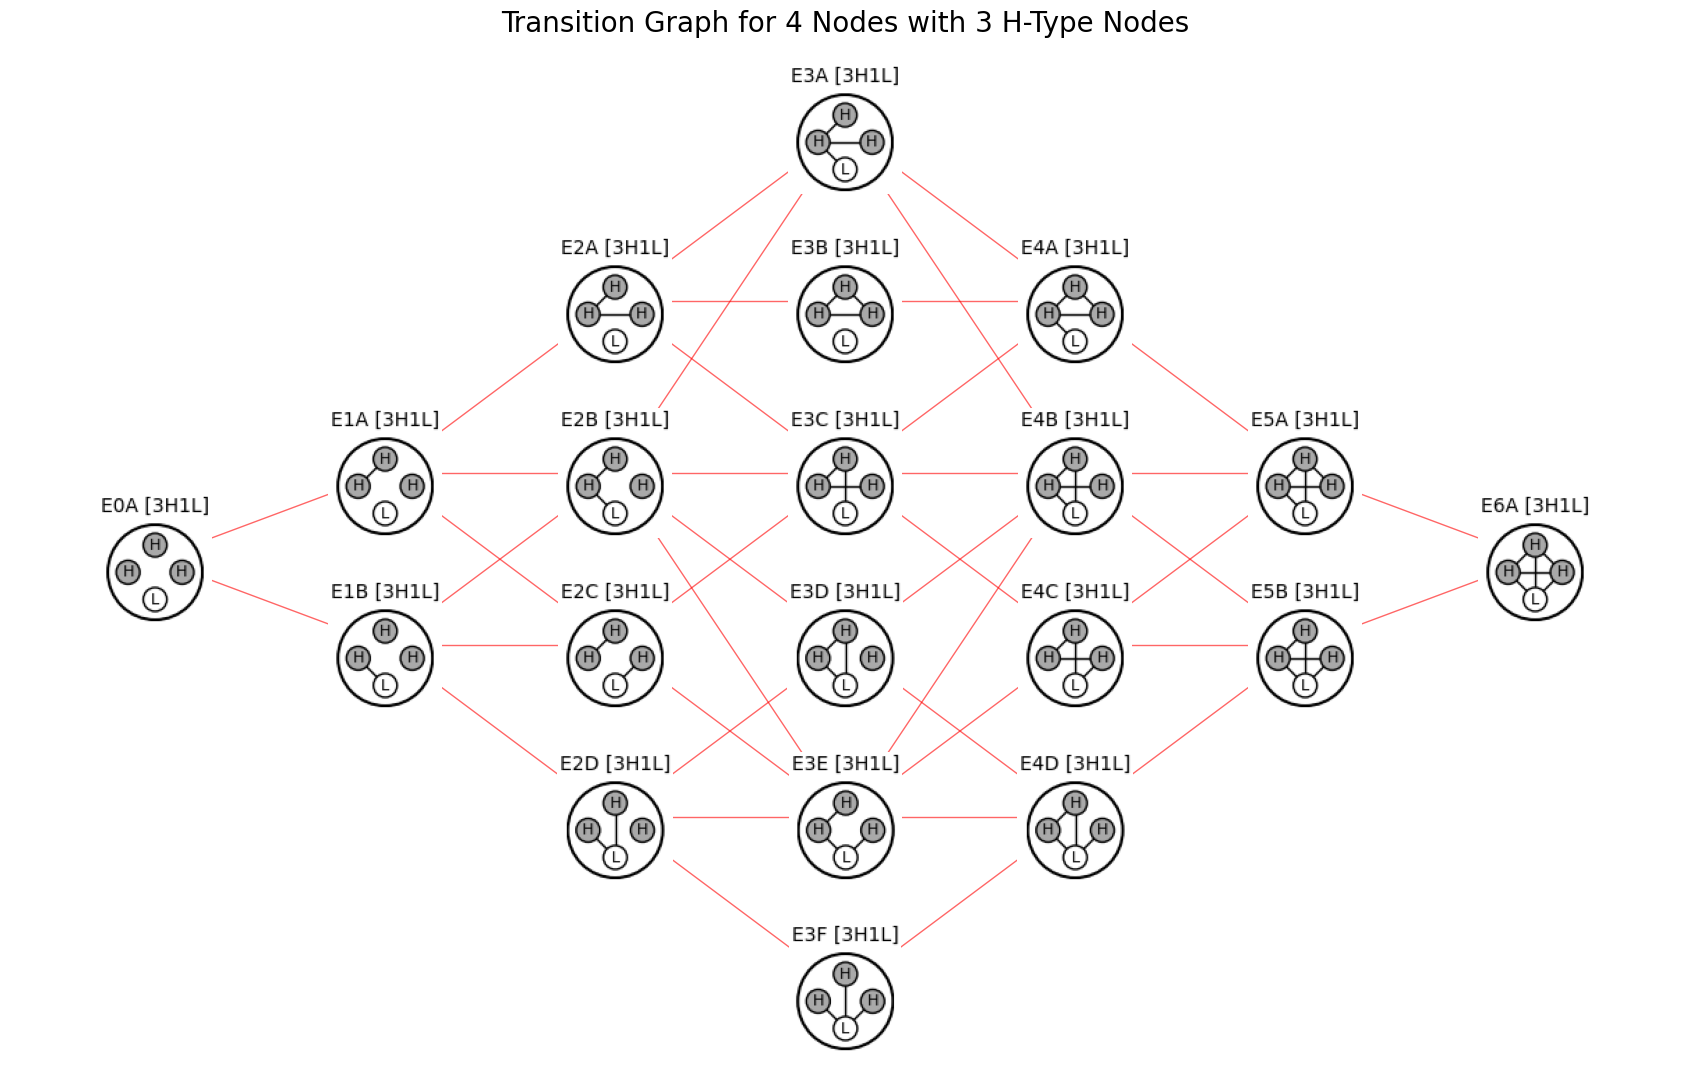

In [20]:
n, n_h = 4, 3

visualize_transition_graph_with_graph_images(
    n, n_h,
    title=f"Transition Graph for {n} Nodes with {n_h} H-Type Nodes"
)
plt.tight_layout()
plt.show()

# Mathematical Solution - Using `sympy`

In [15]:
def label_gen(text):
    return text.replace(' [', ':').replace(']', '').replace(' ', '_').replace(',', '')

In [16]:
def convert_to_rational(expr):
    return expr.xreplace({n: sp.Rational(n) for n in expr.atoms() if isinstance(n, sp.core.numbers.Float)})

In [17]:
def adjacency_matrix_to_latex(adj_matrix, num_h_nodes, radius=1.5, node_offset=np.pi/4):
    # Ensure adj_matrix is a numpy array
    adj_matrix = np.array(adj_matrix)
    num_total_nodes = adj_matrix.shape[0]

    if num_h_nodes > num_total_nodes:
        raise ValueError("Number of H nodes cannot be greater than total number of nodes.")

    num_l_nodes = num_total_nodes - num_h_nodes

    # Create a directed graph from the adjacency matrix
    G = nx.from_numpy_array(adj_matrix, create_using=nx.Graph)

    # Assign labels to nodes
    labels = {}
    node_order = [] # To keep track of the order for placement
    for i in range(num_h_nodes):
        labels[i] = f'H{i + 1}' # Internal label for NetworkX
        node_order.append(f'H{i + 1}') # This is the TikZ node *name* (e.g., H1)
    for i in range(num_l_nodes):
        labels[num_h_nodes + i] = f'L{i + 1}' # Internal label for NetworkX
        node_order.append(f'L{i + 1}') # This is the TikZ node *name* (e.g., L1)

    G = nx.relabel_nodes(G, labels)

    # Start TikZ code
    tikz_code = "\\begin{tikzpicture}[shorten >=1pt,draw=black!50]\n"

    # Dynamic Node Placement (Single Circular Layout)
    center_x, center_y = 0, 0
    
    # Calculate angles for all nodes
    if num_total_nodes > 0: # Avoid division by zero if there are no nodes
        angles = np.linspace(0, 2 * np.pi, num_total_nodes, endpoint=False)
    else:
        angles = [] # No angles needed for 0 nodes

    # Place all nodes on a single circle
    for i, node_name_for_tikz in enumerate(node_order):
        x = center_x + radius * np.cos(angles[i] + node_offset)
        y = center_y + radius * np.sin(angles[i] + node_offset)
        
        # Determine node color based on its type (H or L)
        fill_color = "gray!20" if node_name_for_tikz.startswith('H') else "white"
        
        # Get the display label for LaTeX (e.g., H_1, L_2)
        display_label_content = ""
        if node_name_for_tikz.startswith('H'):
            display_label_content = f'H_{{{node_name_for_tikz[1:]}}}'
        elif node_name_for_tikz.startswith('L'):
            display_label_content = f'L_{{{node_name_for_tikz[1:]}}}'
        
        # This is the crucial change: enclose the math content in {}
        tikz_code += f"\t\\node ({node_name_for_tikz}) at ({'' if x < 0 else ' '}{x:.2f}, {'' if y < 0 else ' '}{y:.2f})\t[circle, draw, fill = {fill_color}]\t{{${display_label_content}$}};\n"

    # Add edges to TikZ code
    for edge in G.edges():
        tikz_code += f"\t\\draw ({edge[0]}) -- ({edge[1]});\n"

    # End TikZ code
    tikz_code += "\\end{tikzpicture}"

    return tikz_code

In [18]:
def simplify_num(expr):
    num, denum = expr.as_numer_denom()
    return ((sp.factor(convert_to_rational(num)))/(sp.factor(convert_to_rational(denum))))


def simplify(expr, max_iter = 20):
    new_expr = expr.copy()
    while max_iter > 0:
        max_iter -= 1
        old_expr = new_expr.copy()
        new_expr = simplify_num(new_expr)
        if new_expr == old_expr:
            break
    return sp.factor(sp.simplify(new_expr))

In [19]:
def list_copy(lst):
    return [x.copy() for x in lst]

In [20]:
def solve_efforts(adj_matrix, theta_vec, beta, e):
    n = len(adj_matrix)
    t_vec = theta_vec.copy()

    global Phi, Delta, Beta

    equations = []
    for i in range(n):
        N_i_size = sum(adj_matrix[i])
        
        term1 = sp.Rational((n + 1)**2, (n - Delta * N_i_size)) * 1/t_vec[i] * Phi
        term2 = t_vec[i] * (n - Delta * N_i_size)
        left_hand_side = (term1 - term2) * e[i]

        right_hand_side = beta

        for j, edge in enumerate(adj_matrix[i]):
            if i == j:
                continue

            coef = -1 * (sum(adj_matrix[j]) * Delta + 1)
            if edge == 1:
                coef += (n + 1) * Delta
            
            right_hand_side += coef * t_vec[j] * e[j]

        equations.append(sp.Eq(left_hand_side, convert_to_rational(right_hand_side)))

    efforts = sp.solve(equations, e)
    for var, sol in efforts.items():
        efforts[var] = convert_to_rational(sol)
    return equations, efforts

In [21]:
def solve_costs(adj_matrix, theta_vec, alpha, gamma, e, c):
    global Phi, Delta
    
    equations, efforts = solve_efforts(adj_matrix, theta_vec, (alpha - gamma), e)

    for i in range(len(adj_matrix)):
        c[i] = gamma - theta_vec[i] * efforts[e[i]]
        for j, edge in enumerate(adj_matrix[i]):
            if i == j:
                continue
            if edge == 1:
                c[i] -= Delta * theta_vec[j] * efforts[e[j]]
    return c, efforts, equations

In [22]:
def solve_profits(adj_matrix, theta_vec, alpha, gamma, e, c, pi):
    global Phi, Delta
    
    c, efforts, equations = solve_costs(adj_matrix, theta_vec, alpha, gamma, e, c)
    c_sum = sum(c)
    n = len(adj_matrix)
    qs = [0] * n
    for i in range(n):
        qs[i] = simplify((alpha + c_sum - (n+1) * c[i]) / (n+1)) 
        
        pi[i] = simplify((qs[i]**2) - (Phi * efforts[e[i]]**2))
    return pi, qs, c, efforts, equations

In [23]:
def solve_network(adj_matrix, n_h, alpha, gamma, theta):
    n = len(adj_matrix)
    theta_vec = [1 for _ in range(n_h)] + [theta for _ in range(n - n_h)]
    
    e = [sp.symbols(f'e^H_{i+1}') for i in range(n_h)] + [sp.symbols(f'e^L_{i+1}') for i in range(n - n_h)]
    c = [sp.symbols(f'c^H_{i+1}') for i in range(n_h)] + [sp.symbols(f'c^L_{i+1}') for i in range(n - n_h)]

    profits, quants, costs, efforts, equations = solve_profits(adj_matrix, theta_vec, alpha, gamma, e, c, [f'pi_{i}' for i in range(n)])
    return profits, quants, costs, efforts, equations

In [24]:
def SolveNetworkLatex(adj_matrix, n_h=2, section_name='', res_dict=None):

    alpha, gamma, theta = sp.symbols('alpha gamma theta')
    initial_profits, quants, costs, efforts, equations = solve_network(adj_matrix, n_h, alpha, gamma, theta)

    labels = {0: '$H_1$', 1: '$H_2$', 2: '$L_1$', 3: '$L_2$'}
    cs = [sp.symbols(f'c^H_{i+1}') for i in range(n_h)] + [sp.symbols(f'c^L_{i+1}') for i in range(len(adj_matrix) - n_h)]
    pis = [sp.symbols(f'pi^H_{i+1}') for i in range(n_h)] + [sp.symbols(f'pi^L_{i+1}') for i in range(len(adj_matrix) - n_h)]
    qs= [sp.symbols(f'q^H_{i+1}') for i in range(n_h)] + [sp.symbols(f'q^L_{i+1}') for i in range(len(adj_matrix) - n_h)]

    if section_name:
        print("\\subsubsection{" + section_name + "}")
    else:
        print("\\subsubsection{" + str(adj_matrix) + '}')

    print(f"\\label{{apx:{label_gen(section_name)}}}", end='\n\n')


    print("\\begin{multicols}{2}")
    print("\\begin{center}")
    print(adjacency_matrix_to_latex(adj_matrix, n_h))
    print("\\end{center}\n\\columnbreak", end='\n\n')

    print(("\\scaleeq{\nEquations: \\begin[[cases]]\n\t" + "\\\\\n\t".join([f"{sp.latex(convert_to_rational(i))}" for i in equations]) + "\n\\end[[cases]]").replace('[[', '{').replace(']]', '}') , end='\n}')
    print("\\end{multicols}\n\n")

    print(("Optimal efforts:\n\n\\scaleeq{\n\\begin[[cases]]\n\t" + "\\\\\n\t".join([f"{sp.latex(e)} &= {sp.latex(simplify_num(s))}" for e, s in efforts.items()]) + "\n\\end[[cases]]").replace('[[', '{').replace(']]', '}') , end='\n}\n\n')
    
    print(("Production Costs:\n\n\\scaleeq{\n\\begin[[cases]]\n\t" + "\\\\\n\t".join([f"{sp.latex(c)} &= {sp.latex(simplify(s))}" for c, s in zip(cs, costs)]) + "\n\\end[[cases]]").replace('[[', '{').replace(']]', '}') , end='\n}\n\n')

    print(("Production Quantities:\n\n\\scaleeq{\n\\begin[[cases]]\n\t" + "\\\\\n\t".join([f"{sp.latex(q)} &= {sp.latex(simplify(s))}" for q, s in zip(qs, quants)]) + "\n\\end[[cases]]").replace('[[', '{').replace(']]', '}'), end='\n}\n\n')

    print(("Profits:\n\n\\begin[[equation]]\n\\label[[eq:" + label_gen(section_name) + "_profit]]\n\\scaledequation{\\begin[[cases]]\n\t" + "\\\\\n\t".join([f"{sp.latex(pi)} &= {sp.latex(simplify(s))}" for pi, s in zip(pis, initial_profits)]) + "\n\\end[[cases]]\n]]\n\\end[[equation]]").replace('[[', '{').replace(']]', '}') , end='\n\n')

    # Calculate Firm Surplus
    FS = 0
    for p in initial_profits:
        FS = simplify_num(FS + p)
    

    # Calculate Consumer Surplus
    Q = 0
    for q in quants:
        Q = simplify_num(Q + q)
    price = simplify_num(alpha - Q)
    CS = simplify_num(Q**2 / 2)

    # Calculate Social Welfare
    SW = simplify_num(FS + CS)
    

    print(f"Total Production:\n\n\\scaleeq[[\n{sp.latex(Q)}".replace('[[', '{'), end='\n}\n\n')
    print(f"Price:\n\n\\scaleeq[[\n{sp.latex(price)}".replace('[[', '{'), end='\n}\n\n')

    print(f"Firm Surplus:\n\n\\scaleeq[[\n{sp.latex(FS)}".replace('[[', '{'), end='\n}\n\n')
    print(f"Consumer Surplus:\n\n\\scaleeq[[\n{sp.latex(CS)}".replace('[[', '{'), end='\n}\n\n')
    print(f"Social Welfare:\n\n\\scaleeq[[\n{sp.latex(SW)}".replace('[[', '{'), end='\n}\n\n')
    
    print('%' + '='*70, end='\n\n')
    # print('\\newpage', end='\n\n')

    results = {
        'profits': initial_profits,
        'quantities': quants,
        'costs': costs,
        'efforts': efforts,
        'equations': equations,
        'firm_surplus': FS,
        'consumer_surplus': CS,
        'social_welfare': SW,
        'matrix': adj_matrix,
    }
    
    if res_dict is not None:
        if section_name:
            res_dict[section_name] = results
        else:
            res_dict[str(adj_matrix)] = results
        return
    
    return results
   

In [25]:
def SolveNetworkLatexWrapper(adj_matrix, n_h, output_file_path, section_name=False, res_dict=None, write_mode='a'):
    # Create a StringIO object to capture the output
    output_capture = io.StringIO()
    
    # Use contextlib.redirect_stdout to redirect the output to the StringIO object
    with contextlib.redirect_stdout(output_capture):
        SolveNetworkLatex(adj_matrix, n_h, section_name=section_name, res_dict=res_dict)
    
    # Get the captured output from the StringIO object
    output_content = output_capture.getvalue()
    
    # Write the captured output to the specified file
    with open(output_file_path, write_mode) as output_file:
        output_file.write(output_content)

# Solution for $n=4$

In [26]:
result_dict = {}

In [27]:
n, n_h = 4, 1

key = f'{n_h}H{n-n_h}L'
result_dict[key] = dict()

for i, network in tqdm(list(enumerate(generate_unique_graphs_with_names(n, n_h)))):
    SolveNetworkLatexWrapper(
        adj_matrix=network['matrix'], 
        n_h=n_h, 
        output_file_path=f'Files/output_nostability_{key}.tex', 
        section_name=network['name'], 
        res_dict=result_dict[key], 
        write_mode='a' if i > 0 else 'w'
    )

100%|██████████| 20/20 [00:24<00:00,  1.24s/it]


In [28]:
n, n_h = 4, 2

key = f'{n_h}H{n-n_h}L'
result_dict[key] = dict()

for i, network in tqdm(list(enumerate(generate_unique_graphs_with_names(n, n_h)))):
    SolveNetworkLatexWrapper(
        adj_matrix=network['matrix'], 
        n_h=n_h, 
        output_file_path=f'Files/output_nostability_{key}.tex', 
        section_name=network['name'], 
        res_dict=result_dict[key], 
        write_mode='a' if i > 0 else 'w'
    )

100%|██████████| 28/28 [00:32<00:00,  1.16s/it]


In [29]:
n, n_h = 4, 3

key = f'{n_h}H{n-n_h}L'
result_dict[key] = dict()

for i, network in tqdm(list(enumerate(generate_unique_graphs_with_names(n, n_h)))):
    SolveNetworkLatexWrapper(
        adj_matrix=network['matrix'], 
        n_h=n_h, 
        output_file_path=f'Files/output_nostability_{key}.tex', 
        section_name=network['name'], 
        res_dict=result_dict[key], 
        write_mode='a' if i > 0 else 'w'
    )

100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


# Proposition 1 Analysis: Condition on $\phi$

In [30]:
all_denominators = dict()

for key, value in result_dict.items():
    all_denominators[key] = set()
    for network, results in tqdm(value.items(), desc=f'Processing {key}'):
        for e, expr in results['efforts'].items():
            _, denum = expr.as_numer_denom()
            all_denominators[key].add(denum)

Processing 3H1L: 100%|██████████| 20/20 [00:00<00:00, 2413.71it/s]


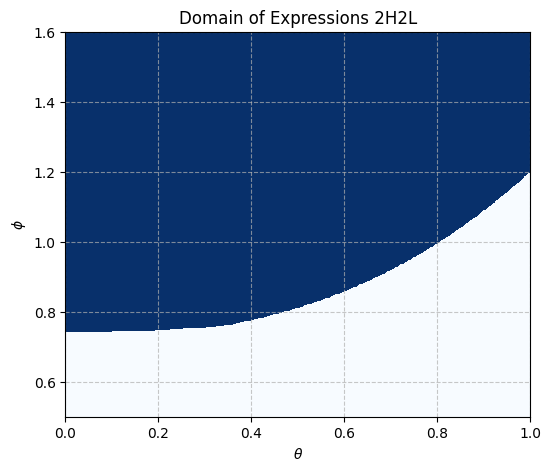

In [31]:
plot_expression_domain(
    expressions=list(all_denominators['2H2L']),
    theta_min=0, theta_max=1,
    phi_min=0.5, phi_max=1.6,
    num_points=500,
    epsilon=1e-9,
    title='Domain of Expressions 2H2L',
    color='Blues'
)
plt.show()

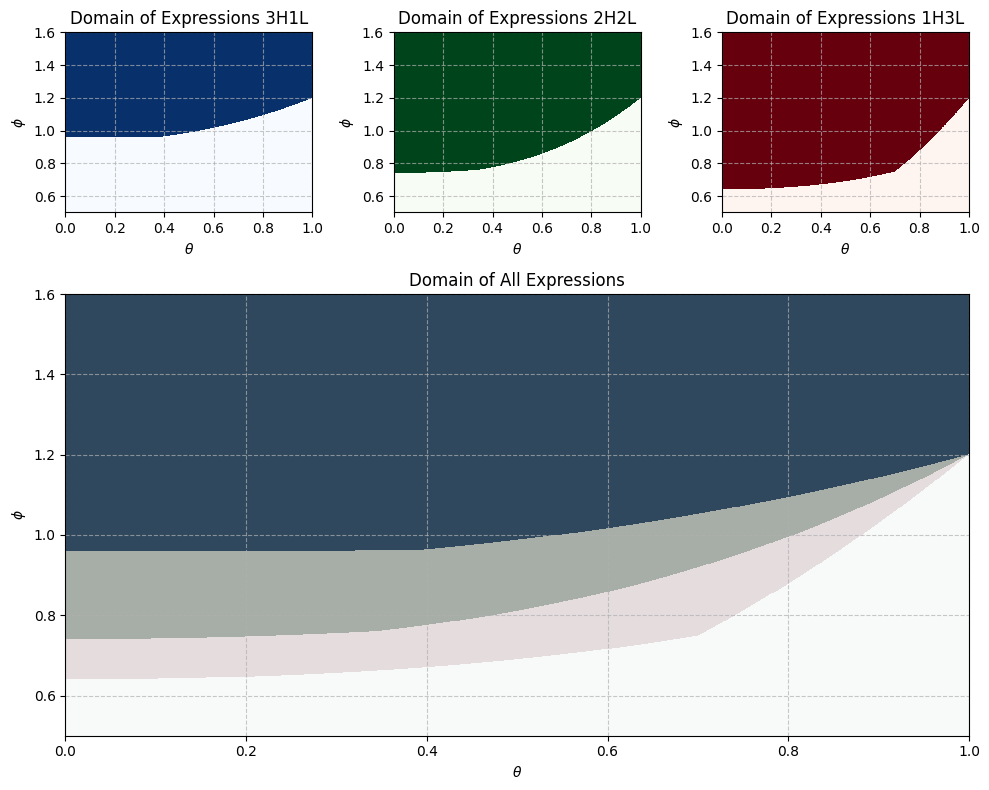

In [41]:
# Plot all last plots together
# Create a figure with GridSpec for fine control
fig = plt.figure(figsize=(10, 8))
gs = GridSpec(3, 3, figure=fig)

# First row: 3 separate subplots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

# Second row: 1 subplot spanning all columns
ax4 = fig.add_subplot(gs[1:, :])

plot_expression_domain(
    expressions=list(all_denominators['3H1L']),
    theta_min=0, theta_max=1,
    phi_min=0.5, phi_max=1.6,
    num_points=900,
    epsilon=1e-9,
    title='Domain of Expressions 3H1L',
    ax=ax1,
    color='Blues'  # Use a different color for the first plot
)

plot_expression_domain(
    expressions=list(all_denominators['2H2L']),
    theta_min=0, theta_max=1,
    phi_min=0.5, phi_max=1.6,
    num_points=900,
    epsilon=1e-9,
    title='Domain of Expressions 2H2L',
    ax=ax2,
    color='Greens'  # Use a different color for the second plot
)

plot_expression_domain(
    expressions=list(all_denominators['1H3L']),
    theta_min=0, theta_max=1,
    phi_min=0.5, phi_max=1.6,
    num_points=900,
    epsilon=1e-9,
    title='Domain of Expressions 1H3L',
    ax=ax3,
    color='Reds'  # Use a different color for the third plot
)

# Plot all expressions together and merge the bottom ax = ax[1, 0] + ax[1, 1] + ax[1, 2]
plot_expression_domain(
    expressions=all_denominators['1H3L'],
    theta_min=0, theta_max=1,
    phi_min=0.5, phi_max=1.6,
    num_points=900,
    epsilon=1e-9,
    title='Domain of All Expressions',
    ax=ax4,
    alpha=0.5,
    color='Reds'  # Use a different color for the merged plot
)
plot_expression_domain(
    expressions=all_denominators['2H2L'],
    theta_min=0, theta_max=1,
    phi_min=0.5, phi_max=1.6,
    num_points=900,
    epsilon=1e-9,
    title='Domain of All Expressions',
    ax=ax4,
    alpha=0.5,
    color='Greens'  # Use a different color for the merged plot
)
plot_expression_domain(
    expressions=all_denominators['3H1L'],
    theta_min=0, theta_max=1,
    phi_min=0.5, phi_max=1.6,
    num_points=900,
    epsilon=1e-9,
    title='Domain of All Expressions',
    ax=ax4,
    alpha=0.5,
    color='Blues'  # Use a different color for the merged plot
)

plt.tight_layout()
plt.savefig('Files/combined_phi_cond_new.png', dpi=500, bbox_inches='tight')

# Check the condition for $\theta=1$

This is the similar case as Goyal 2001, by considering homogeneous firms. Goyal argues that the condition on the cost coefficient is $\phi > \frac{n}{n+1}$. This in the case of $n=4$ means that $\phi>\frac{4}{5}=0.8$, where our simulation shows it should be $\phi>1.2$. Here we find the set of structures for which Goyal's condition does not satisfy an enterior solution.

In [ ]:
network_effort_dics = dict()

In [61]:
# agents = sp.symbols('e^H_1 e^H_2 e^L_1 e^L_2')
phi_var = sp.Symbol('phi')

for network_name, results in tqdm(result_dict['2H2L'].items()):
    network_effort_dics[network_name] = list()
    for agent, effort in results['efforts'].items():
        new_effort = simplify(effort).subs({
            sp.Symbol('theta'): sp.Integer(1),
            sp.Symbol('gamma'): sp.Integer(0),
            sp.Symbol('alpha'): sp.Integer(1)
        })
        network_effort_dics[network_name].append((agent, sp.lambdify(phi_var, new_effort, 'numpy')))

100%|██████████| 28/28 [00:02<00:00, 10.51it/s]


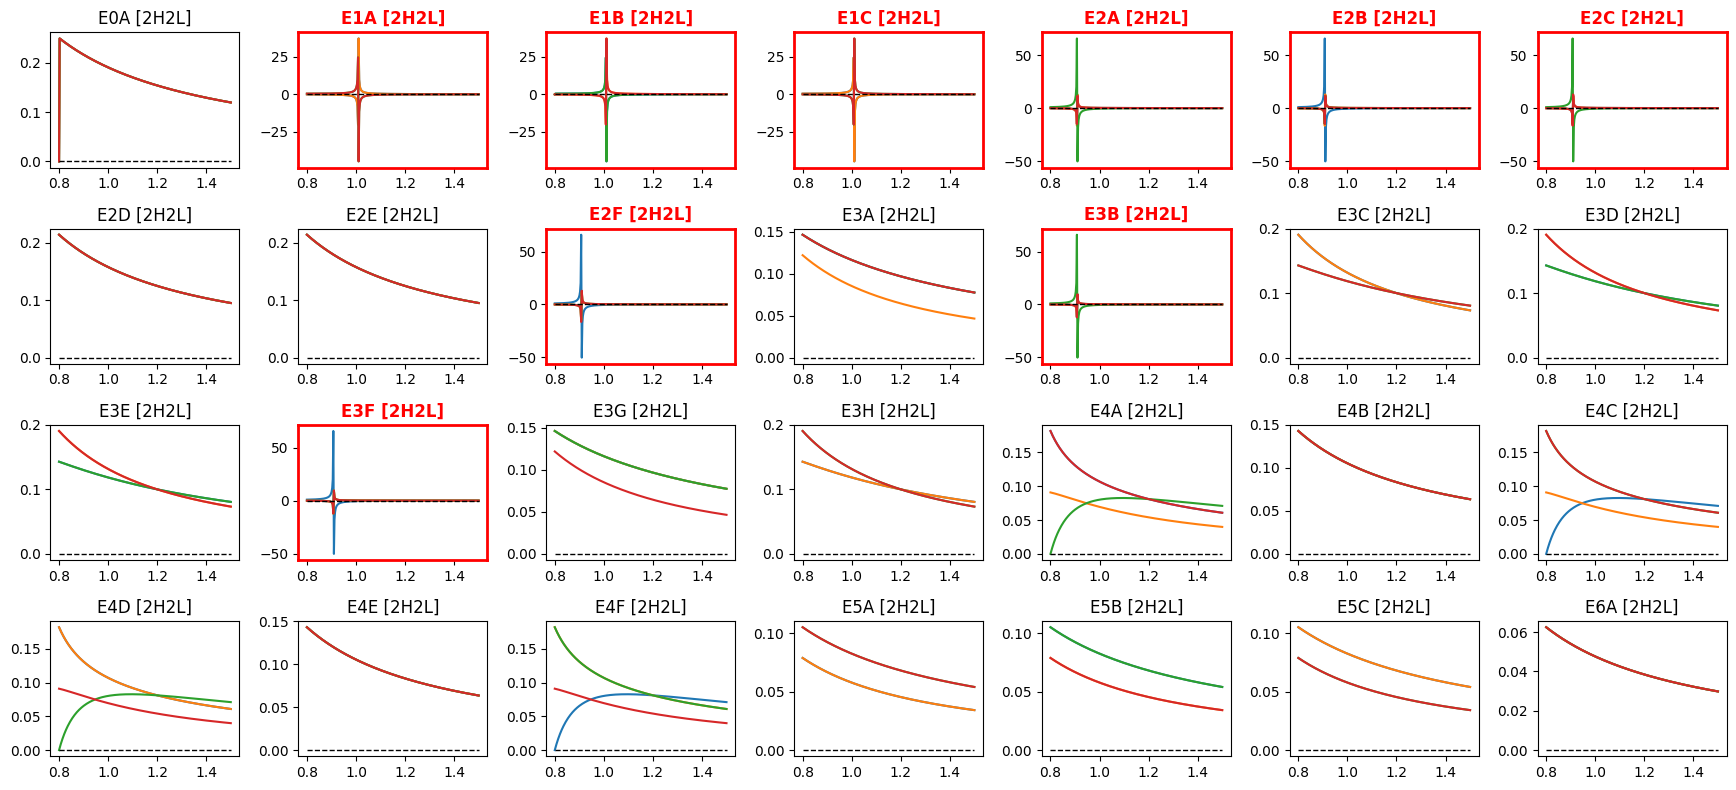

In [85]:
phi_vals = np.linspace(0.8, 1.5, 300)

neg_network_list = []

nrow, ncol = 4, 7
fig, axs = plt.subplots(nrow, ncol, figsize=(ncol * 2.5, nrow * 2))
for ax, (network_name, effort_list) in zip(axs.flatten(), network_effort_dics.items()):
    is_negative = False
    for agent, effort_func in effort_list:
        e_v_vals = effort_func(phi_vals)
        if np.any(e_v_vals < 0):
            is_negative = True
        ax.plot(phi_vals, e_v_vals, label=str(agent))
    ax.set_title(network_name)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.hlines(0, xmin=phi_vals[0], xmax=phi_vals[-1], colors='k', linestyles='--', linewidth=1)
    if is_negative:
        neg_network_list.append(network_name)
        ax.set_title(network_name, color='red', fontsize=12, fontweight='bold')
        for spine in ax.spines.values():
            spine.set_edgecolor('red')
            spine.set_linewidth(2)

plt.tight_layout()

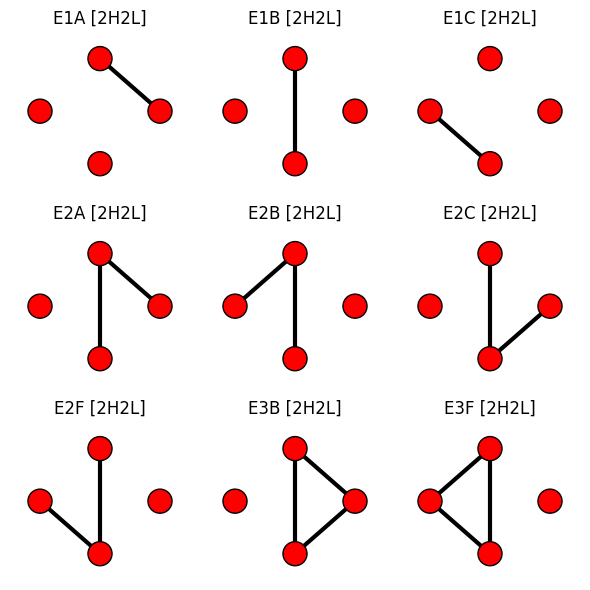

In [104]:
# Plot networks with negative efforts highlighted
ncol = 3
nrow = int(np.ceil(len(neg_network_list) / ncol))

network_matrix_map = generate_unique_graphs_with_names(n=4, n_h=2)
network_matrix_map = {g['name']: g['matrix'] for g in network_matrix_map}

fig, axs = plt.subplots(nrow, ncol, figsize=(ncol * 2, nrow * 2))
for ax, network_name in zip(axs.flatten(), neg_network_list):
    effort_list = network_effort_dics[network_name]
    note_types = []
    for agent, effort_func in effort_list:
        e_v_vals = effort_func(phi_vals)
        note_types.append('red' if np.any(e_v_vals < 0) else 'black')
    
    adj_matrix = network_matrix_map[network_name]

    G = nx.from_numpy_array(adj_matrix)
    pos = nx.circular_layout(G)
    nx.draw_networkx_edges(G, pos, ax=ax, width=3)
    nx.draw_networkx_nodes(G, pos, ax=ax, node_color=note_types, edgecolors='black', node_size=300)
    ax.set_title(network_name)
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.axis('off')


for ax in axs.flatten()[len(neg_network_list):]:
    fig.delaxes(ax)

plt.tight_layout()

## Solve the model for homogemeous case with $n=4$


Let $\phi$ denote the variable of interest. Define
$$
\eta_1=\tfrac{3}{5},\qquad \eta_2=\tfrac{4}{5},\qquad
A(\phi):=\frac{\eta_1}{\phi-\eta_1^2}=\frac{3/5}{\phi-9/25},\qquad
B(\phi):=\frac{\eta_2}{\phi-\eta_2^2}=\frac{4/5}{\phi-16/25}.
$$
Starting from the linear system
$$
\begin{aligned}
e_1 &= A\Big(\tfrac{1}{5}+\eta_1 e_1-\tfrac{2}{5}e_2\Big),\\[4pt]
e_2 &= B\Big(\tfrac{1}{5}-\tfrac{4}{5}e_1-\tfrac{1}{5}e_2\Big),
\end{aligned}
$$
one rearranges to obtain the $2\times2$ linear system
$$
\begin{pmatrix}
1-\dfrac{3A}{5} & \dfrac{2A}{5}\\[6pt]
\dfrac{4B}{5} & 1+\dfrac{B}{5}
\end{pmatrix}
\begin{pmatrix} e_1\\ e_2\end{pmatrix}
=
\begin{pmatrix}\dfrac{A}{5}\\[6pt]\dfrac{B}{5}\end{pmatrix}.
$$
Let
$$
\Delta(\phi):=\det
\begin{pmatrix}
1-\dfrac{3A}{5} & \dfrac{2A}{5}\\[6pt]
\dfrac{4B}{5} & 1+\dfrac{B}{5}
\end{pmatrix}
=1+\frac{B}{5}-\frac{3A}{5}-\frac{11AB}{25}.
$$
By Cramer’s rule the unique solution (when $\Delta\neq0$) is
$$
e_1=\dfrac{A(5-B)}{25\,\Delta},\qquad
e_2=\dfrac{B(5-7A)}{25\,\Delta},
$$
valid for all $\phi$ such that denominators in $A,B,\Delta$ are nonzero.

---

### Positivity conditions

1. **Signs of $A(\phi)$ and $B(\phi)$:**
   $$
   A(\phi)>0,\, B(\phi)>0 \iff \phi>\tfrac{16}{25}=0.64.
   $$

2. **Numerator signs:**
   $$
   A(5-B)>0,\quad B(5-7A)>0.
   $$
   For $\phi>16/25$, $A,B>0$, hence
   $$
   5-B>0,\qquad 5-7A>0.
   $$

   The condition $5-7A>0$ is equivalent to $A<5/7$, i.e.
   $$
   \frac{3/5}{\phi-9/25}<\frac{5}{7}
   \;\Longleftrightarrow\;
   \phi-9/25>\frac{3/5}{5/7}=\frac{21}{25}
   \;\Longleftrightarrow\;
   \phi>\frac{30}{25}=1.2.
   $$

   Similarly, $5-B>0$ holds for $\phi>0.8$, which is automatically satisfied when $\phi>1.2$.

3. **Sign of $\Delta(\phi)$:**
   $$
   \Delta(\phi)=1+\frac{B}{5}-\frac{3A}{5}-\frac{11AB}{25}.
   $$
   At $\phi=1.2$, one obtains $A(1.2)=5/7$, $B(1.2)=10/7$, and hence
   $$
   \Delta(1.2)=1+\frac{2}{7}-\frac{3}{7}-\frac{11(50/49)}{25}\approx0.41>0.
   $$
   Since $A(\phi)$ and $B(\phi)$ are strictly decreasing in $\phi$ for $\phi>16/25$,
   $\Delta(\phi)$ remains positive for all $\phi\ge1.2$.

---

### Conclusion

For $\phi\ge1.2$,
$$
A(\phi)>0,\quad B(\phi)>0,\quad 5-B(\phi)>0,\quad 5-7A(\phi)>0,\quad \Delta(\phi)>0,
$$
implying
$$
e_1>0,\qquad e_2>0.
$$
Conversely, if $e_2>0$ then $5-7A>0$, which is equivalent to $\phi>1.2$.

$$
\boxed{\text{Both } e_1 \text{ and } e_2 \text{ are positive if and only if } \phi>1.2.}
$$


# Stability Condition Generation

In [48]:
def prove_stability(n, n_h, sol_dict, network_name, res_dict=None):
    """
    Proves stability of the network by checking all possible deviation
    from the transition matrix.

    Args:
        n (int): Total number of nodes.
        n_h (int): Number of H nodes.
        sol_dict (dict): Dictionary with results from SolveNetworkLatexWrapper.
        network_name (str): Name of the network for which to prove stability.
        res_dict (dict, optional): Dictionary to store results. Defaults to None.
    
    Prints:
        Stability conditions for each deviation.
        Final stability condition.
    """

    node_names = [f'$H_{i+1}$' for i in range(n_h)] + [f'$L_{i+1}$' for i in range(n - n_h)]

    cnd_dict = {'add': [], 'remove': []}
    
    transition_graph = generate_detailed_transition_map(n, n_h)
    trns_dict = transition_graph[network_name]
    print(f"\\subsubsection[[Stability conditions for: \hyperref[apx:{label_gen(network_name)}][[{network_name})])]".replace('[[', '{').replace(')]', '}'), end='\n')
    print("\\label{apx:" + label_gen(network_name) + "_stability_cond}\n")

    print("\\begin{itemize}\n")

    for transition in trns_dict['add']:
        target_network = transition['target_name']
        nodes_involved = transition['nodes_involved_map']
        print(f"\t\\item Adding an edge between nodes {', '.join([node_names[i] for i, _ in nodes_involved])}:", end=" ")
        print(f"\\hyperref[apx:{label_gen(network_name)}][[{network_name})] $\\to$ \\hyperref[apx:{label_gen(target_network)}][[{target_network})]".replace('[[', '{').replace(')]', '}'), end='\n\n')
        
        conditions = []

        print("\t\\begin{itemize}\n")
        print(f"\t\t\\item For {node_names[nodes_involved[0][0]]} not to be profitable:", end='\n\n\t\t\\scaleeq{\n\t\t')
        eq1 = sol_dict[network_name  ]['profits'][nodes_involved[0][0]] #/ (sol_dict['alpha'] - sol_dict['gamma'])**2
        eq2 = sol_dict[target_network]['profits'][nodes_involved[0][1]] #/ (sol_dict['alpha'] - sol_dict['gamma'])**2
        print(sp.latex(eq1 > eq2), end='\n\t\t}\n\n')
        conditions.append(sp.Gt(eq1, eq2))
        
        print(f"\t\t\\item For {node_names[nodes_involved[1][0]]} not to be profitable:", end='\n\n\t\t\\scaleeq{\n\t\t')
        eq1 = sol_dict[network_name]['profits'][nodes_involved[1][0]] #/ (sol_dict['alpha'] - sol_dict['gamma'])**2
        eq2 = sol_dict[target_network]['profits'][nodes_involved[1][1]] #/ (sol_dict['alpha'] - sol_dict['gamma'])**2
        print(sp.latex(eq1 > eq2), end='\n\t\t}\n\n')
        print("\t\\end{itemize}\n")
        conditions.append(sp.Gt(eq1, eq2))

        cnd_dict['add'].append(tuple(conditions))
    
    for transition in trns_dict['remove']:
        target_network = transition['target_name']
        nodes_involved = transition['nodes_involved_map']
        print(f"\t\\item Removing an edge between nodes {', '.join([node_names[i] for i, _ in nodes_involved])}:", end=" ")
        print(f"\\hyperref[apx:{label_gen(network_name)}][[{network_name})] $\\to$ \\hyperref[apx:{label_gen(target_network)}][[{target_network})]".replace('[[', '{').replace(')]', '}'), end='\n\n')
        
        conditions = []

        print("\t\\begin{itemize}\n")
        print(f"\t\t\\item For {node_names[nodes_involved[0][0]]} not to be profitable:", end='\n\n\t\t\\scaleeq{\n\t\t')
        eq1 = sol_dict[network_name]['profits'][nodes_involved[0][0]] #/ (sol_dict['alpha'] - sol_dict['gamma'])**2
        eq2 = sol_dict[target_network]['profits'][nodes_involved[0][1]] #/ (sol_dict['alpha'] - sol_dict['gamma'])**2
        print(sp.latex(eq1 >= eq2), end='\n\t\t}\n\n')
        conditions.append(sp.Ge(eq1, eq2))

        print(f"\t\t\\item For {node_names[nodes_involved[1][0]]} not to be profitable:", end='\n\n\t\t\\scaleeq{\n\t\t')
        eq1 = sol_dict[network_name]['profits'][nodes_involved[1][0]]
        eq2 = sol_dict[target_network]['profits'][nodes_involved[1][1]]
        print(sp.latex(eq1 >= eq2), end='\n\t\t}\n\n')
        print("\t\\end{itemize}\n")
        conditions.append(sp.Ge(eq1, eq2))

        cnd_dict['remove'].append(tuple(conditions))

    print("\\end{itemize}\n")
    print("%==========================================\n\n")
    # print("\\newpage\n")

    if res_dict is not None:
        res_dict[network_name] = cnd_dict
    else:
        return cnd_dict
    
    return


In [49]:
def Prove_Stability_Wrapper(n, n_h, sol_dict, output_file_path, network_name, res_dict=None, mode='a'):
    """
    Wrapper function to prove stability and write results to a file.
    
    Args:
        n (int): Total number of nodes.
        n_h (int): Number of H nodes.
        sol_dict (dict): Dictionary with results from SolveNetworkLatexWrapper.
        output_file_path (str): Path to the output file.
        network_name (str): Name of the network for which to prove stability.
        result_dict (dict, optional): Dictionary to store results. Defaults to None.
        mode (str): Mode for writing to the file ('w' for write, 'a' for append). Defaults to 'a'.
    """
    # Create a StringIO object to capture the output
    output_capture = io.StringIO()
    
    # Use contextlib.redirect_stdout to redirect the output to the StringIO object
    with contextlib.redirect_stdout(output_capture):
        prove_stability(n, n_h, sol_dict, network_name, res_dict)
    
    # Get the captured output from the StringIO object
    output_content = output_capture.getvalue()
    
    # Write the captured output to the specified file
    with open(output_file_path, mode) as output_file:
        output_file.write(output_content)

In [59]:
conditions_dict = {}

In [60]:
n, n_h = 4, 1

key = f'{n_h}H{n-n_h}L'
conditions_dict[key] = dict()

for i, network in tqdm(list(enumerate(generate_unique_graphs_with_names(n, n_h)))):
    Prove_Stability_Wrapper(
        n=n, 
        n_h=n_h, 
        sol_dict=result_dict[key], 
        output_file_path=f'Files/stability_conditions_{key}.tex', 
        network_name=network['name'], 
        res_dict=conditions_dict[key], 
        mode='a' if i > 0 else 'w'
    )

100%|██████████| 20/20 [00:00<00:00, 47.45it/s]


In [61]:
n, n_h = 4, 2

key = f'{n_h}H{n-n_h}L'
conditions_dict[key] = dict()

for i, network in tqdm(list(enumerate(generate_unique_graphs_with_names(n, n_h)))):
    Prove_Stability_Wrapper(
        n=n, 
        n_h=n_h, 
        sol_dict=result_dict[key], 
        output_file_path=f'Files/stability_conditions_{key}.tex', 
        network_name=network['name'], 
        res_dict=conditions_dict[key], 
        mode='a' if i > 0 else 'w'
    )

100%|██████████| 28/28 [00:00<00:00, 50.87it/s]


In [62]:
n, n_h = 4, 3

key = f'{n_h}H{n-n_h}L'
conditions_dict[key] = dict()

for i, network in tqdm(list(enumerate(generate_unique_graphs_with_names(n, n_h)))):
    Prove_Stability_Wrapper(
        n=n, 
        n_h=n_h, 
        sol_dict=result_dict[key], 
        output_file_path=f'Files/stability_conditions_{key}.tex', 
        network_name=network['name'], 
        res_dict=conditions_dict[key], 
        mode='a' if i > 0 else 'w'
    )

100%|██████████| 20/20 [00:00<00:00, 57.76it/s]


# Numerical Evaluation of the Stability Domain

In [63]:
PHI_VAL = sp.Rational(3, 2)

In [64]:
def find_tipping_point(expr, steps=10, start=0.0, end=1.0, rounding=3):
    """
    Finds the tipping point of an expression by recrsively substituting
    the value of theta and checking if the expression is positive.
    
    Args:
        expr (sympy expression): The expression to check.
        steps (int): Number of steps to take in the search.
        start (float): Starting value of theta.
        end (float): Ending value of theta.
        rounding (int): Number of decimal places to round the result.

    Returns:
        float: The tipping point value of theta, rounded to the specified number of decimal places.
    """

    theta = sp.symbols('theta')
    if steps == 0:
        return np.round((start + end) / 2, rounding)
    
    mid = (start + end) / 2
    substituted_expr = expr.subs(theta, mid)

    start_val = expr.subs(theta, start)

    if substituted_expr == start_val:
        return find_tipping_point(expr, steps - 1, mid, end)
    else:
        return find_tipping_point(expr, steps - 1, start, mid)

In [65]:
def solve_inequality_theta_num(expr, num_points=20):
    """
    Solves the inequality for theta numerically by substituting phi and gamma
    with their values and checking the sign of the expression for different
    values of theta. Returns the interval where the expression is positive.

    Args:
        expr (sympy expression): The expression to check.
        num_points (int): Number of points to check in the interval [0, 1].
    """
    global PHI_VAL
    theta = sp.symbols('theta')

    expr = expr.subs({
        sp.symbols('phi'): PHI_VAL,
        sp.symbols('gamma'): 0,
        sp.symbols('alpha'): 1,
    }).simplify()

    # simulate the sides of the inequality for different values of theta
    theta = sp.symbols('theta')
    results = []
    for theta_val in np.linspace(0, 1, num_points):
        expr_val = expr.subs({theta: theta_val})
        results.append(1 if expr_val else -1)
    results = np.array(results)

    # find number of times the sign of the expression changes
    sign_changes = np.where(np.diff(np.sign(results)))[0]

    if len(sign_changes) == 0:
        if results[num_points // 2] > 0:
            return sp.Interval(0, 1)
        return sp.EmptySet
    
    if len(sign_changes) == 1:
        tipping_point = find_tipping_point(expr)
        
        if expr.subs({theta: tipping_point/2}):
            return sp.Interval(0, tipping_point)
        return sp.Interval(tipping_point, 1)

    try:
        print(expr)
        solution = sp.solveset(expr, theta, domain=sp.Interval(0, 1)).evalf()
        return solution
    except Exception as _:
        return sp.EmptySet

In [66]:
def solve_inequality_theta(expr):
    """
    Solves the inequality for theta given an expression.
    
    Args:
        expr (sympy expression): The expression to solve.
    
    Returns:
        sympy Interval: The solution interval for theta.
    """
    global PHI_VAL
    theta = sp.symbols('theta')

    expr = expr.subs({
        sp.symbols('phi'): PHI_VAL,
        sp.symbols('gamma'): 0,
        sp.symbols('alpha'): 1,
    }).simplify()

    try:
        solution = sp.solveset(expr, theta, domain=sp.Interval(0, 1)).evalf()
        return solution
    except Exception as _:
        return sp.EmptySet

In [67]:
def generate_stability_domain(cond_dict):
    """
    Generates the stability domain based on the conditions provided in cond_dict.

    Args:
        cond_dict (dict): Dictionary containing stability conditions for each network.
            should have the structure:
            {
                'add': {
                    'network_name': [(condition1, condition2), ...],
                    ...
                },
                'remove': {
                    'network_name': [(condition1, condition2), ...],
                    ...
                }
            }

    Returns:
        SymPy expression representing the stability domain.
    """
    global PHI_VAL

    add_intervals = []
    remove_intervals = []

    for (cnd1, cnd2) in cond_dict['add']:
        # solution1 = solve_inequality_theta(cnd1)
        # solution2 = solve_inequality_theta(cnd2)
        solution1 = solve_inequality_theta_num(cnd1)
        solution2 = solve_inequality_theta_num(cnd2)

        add_intervals.append(sp.Union(solution1, solution2))
    

    for (cnd1, cnd2) in cond_dict['remove']:
        # solution1 = solve_inequality_theta(cnd1)
        # solution2 = solve_inequality_theta(cnd2)
        solution1 = solve_inequality_theta_num(cnd1)
        solution2 = solve_inequality_theta_num(cnd2)

        remove_intervals.append(sp.Intersection(solution1, solution2))
    
    # return add_intervals, remove_intervals

    # Combine all intervals from both add and remove conditions
    all_intervals = sp.Intersection(*add_intervals, *remove_intervals)
    # Simplify the combined intervals
    simplified_intervals = sp.simplify(all_intervals)
    return simplified_intervals

In [68]:
def create_table_of_stability_domains(n, n_h, phi_val, conditions_dict, print_table=False, progress=False):
    """
    Creates a table of stability domains for different networks.

    Args:
        n (int): Total number of nodes.
        n_h (int): Number of H nodes.
        phi_val (float): Value of phi to use in the calculations.
        conditions_dict (dict): Dictionary containing stability conditions for each network.

    prints:
        Stability domains for each network in LaTeX format.
    """
    global PHI_VAL
    PHI_VAL = phi_val

    prgs = tqdm if progress else (lambda x: x)

    stability_domains = []
    key = f'{n_h}H{n-n_h}L'

    for network_name, cond_dict in prgs(conditions_dict[key].items()):
        stability_domain = generate_stability_domain(cond_dict)
        stability_domains.append((network_name, stability_domain))
    
    df = pd.DataFrame({
        'Network': [network_name for network_name, _ in stability_domains],
        f'Stability Domain $\\phi = {sp.latex(phi_val)}$': [sp.latex(domain) for _, domain in stability_domains]
    })

    if print_table:
        print("\\begin{table}[h!]\n\\centering\n\\begin{tabular}{cc}\n\\topline\nNetwork & Stability Domain \\\\\n\\midline")
        for index, row in df.iterrows():
            key_temp = f'Stability Domain $\\phi = {phi_val.evalf()}$'
            print(f"{row['Network']} & ${row[key_temp]}$ \\\\")
        print("\\bottomline\n\\end{tabular}\n\\caption{Stability domains for networks with " + f"{n_h}H{n-n_h}L nodes." + "}\n\\label{tab:stability_domains_" + f"{n_h}H{n-n_h}L" + "}\n\\end{table}\n")
    return df

In [ ]:
n, n_h = 4, 1

df_list = [
    create_table_of_stability_domains(n, n_h, sp.Rational(val, 100), conditions_dict)
    for val in tqdm(list(range(125, 505, 5)))
]

res_df = None
for i, df in enumerate(df_list):
    if i == 0:
        res_df = df
    else:
        res_df = pd.merge(res_df, df, on='Network', how='inner')
res_df.to_csv(f'Files/stability_domains_{n_h}H{n-n_h}L_combined_100_res.csv', index=False)
res_df

In [ ]:
n, n_h = 4, 2

df_list = [
    create_table_of_stability_domains(n, n_h, sp.Rational(val, 100), conditions_dict)
    for val in tqdm(list(range(125, 505, 5)))
]

res_df = None
for i, df in enumerate(df_list):
    if i == 0:
        res_df = df
    else:
        res_df = pd.merge(res_df, df, on='Network', how='inner')
res_df.to_csv(f'Files/stability_domains_{n_h}H{n-n_h}L_combined_100_res.csv', index=False)
res_df

In [ ]:
n, n_h = 4, 3

df_list = [
    create_table_of_stability_domains(n, n_h, sp.Rational(val, 100), conditions_dict)
    for val in tqdm(list(range(125, 505, 5)))
]

res_df = None
for i, df in enumerate(df_list):
    if i == 0:
        res_df = df
    else:
        res_df = pd.merge(res_df, df, on='Network', how='inner')
res_df.to_csv(f'Files/stability_domains_{n_h}H{n-n_h}L_combined_100_res.csv', index=False)
res_df

## Plot Stability Domains

/var/folders/2_/37s1zdlx37z13rt227qsdtvr0000gp/T/ipykernel_10739/342908982.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_grid = cm.get_cmap('tab20', len(network_names))
/var/folders/2_/37s1zdlx37z13rt227qsdtvr0000gp/T/ipykernel_10739/342908982.py:83: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('tab10', max(10, len(stable_names)))


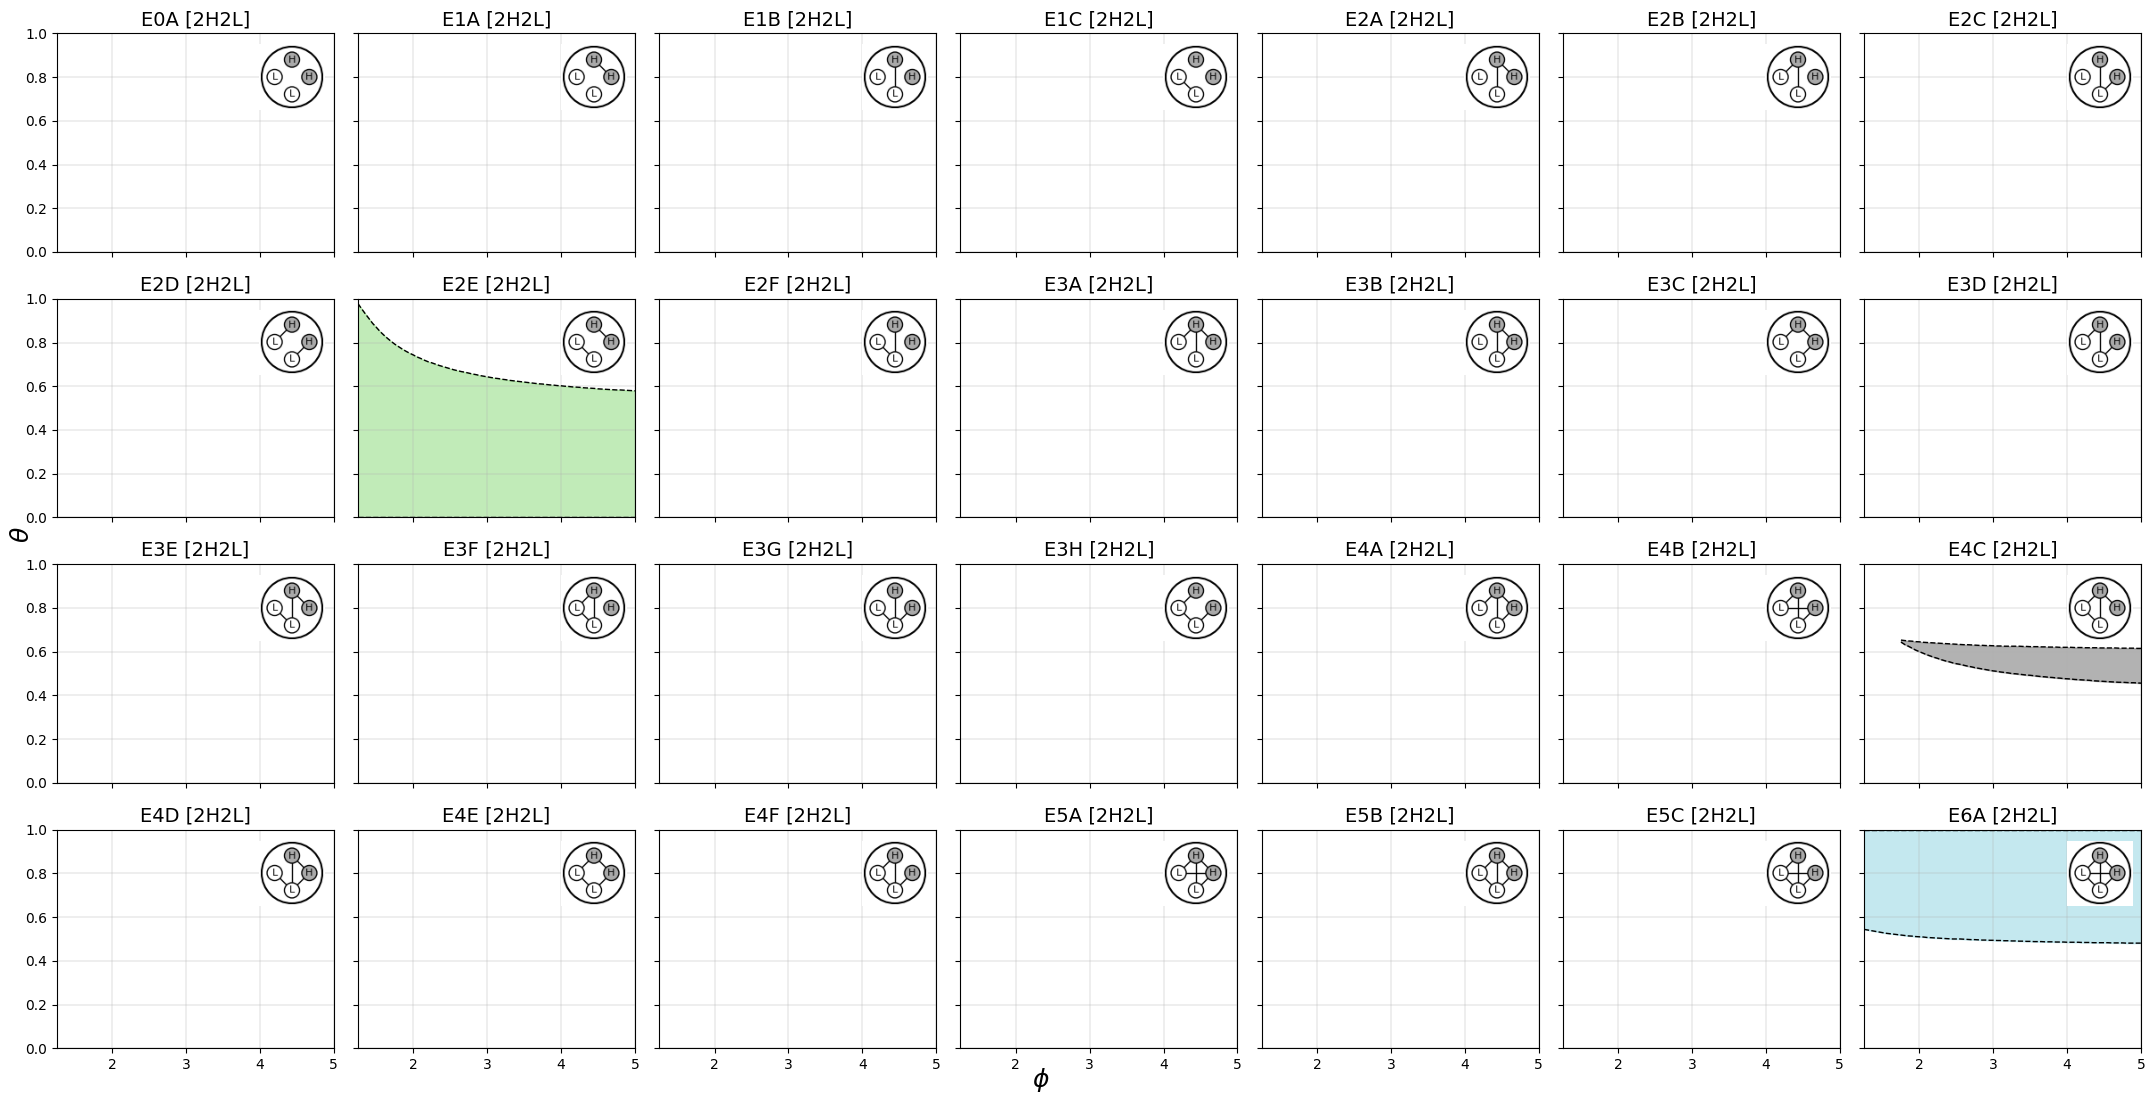

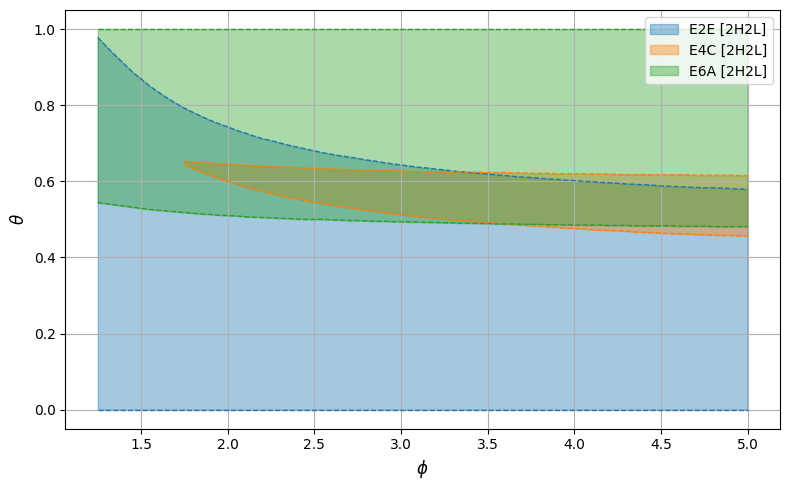

In [111]:
draw_grid_stability_plot(
    'Files/stability_domains_2H2L_combined.csv', 
    n = 4, n_h = 2, 
    nrow = 4, ncol=7, 
    gts=14,
    save_path1='Files/stability_grid_2H2L.png',
    save_path2='Files/stability_stable_2H2L.png'
    )

/var/folders/2_/37s1zdlx37z13rt227qsdtvr0000gp/T/ipykernel_10739/342908982.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_grid = cm.get_cmap('tab20', len(network_names))
/var/folders/2_/37s1zdlx37z13rt227qsdtvr0000gp/T/ipykernel_10739/342908982.py:83: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('tab10', max(10, len(stable_names)))


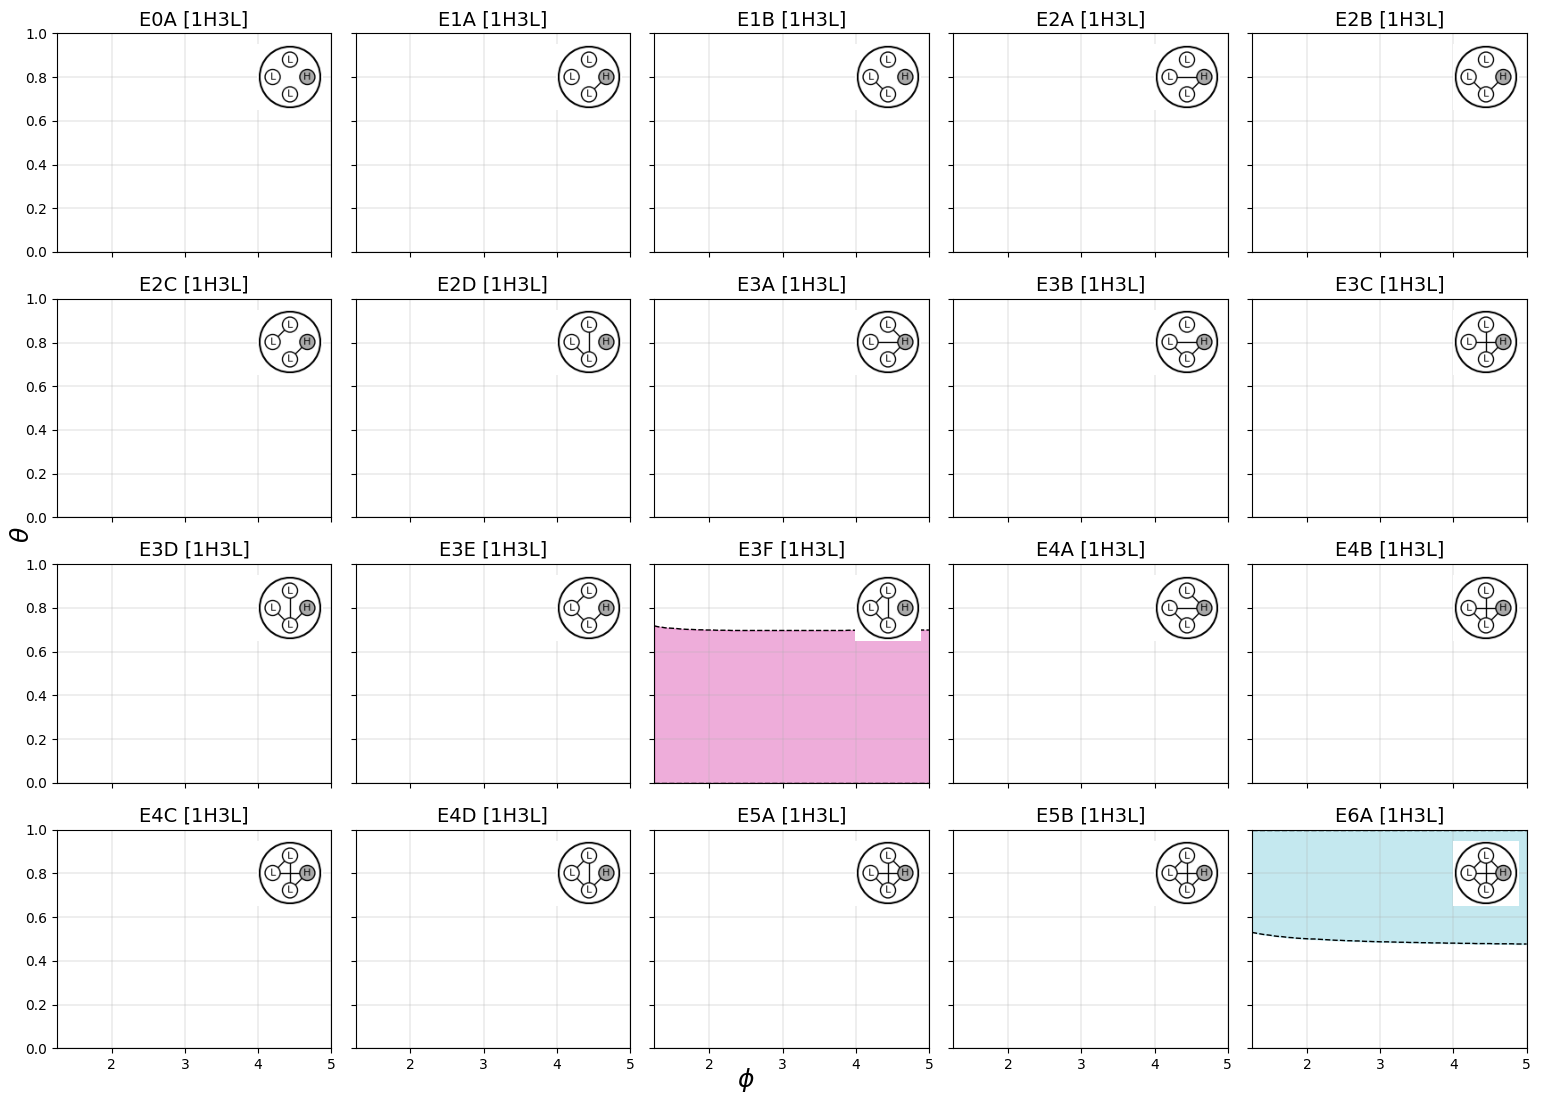

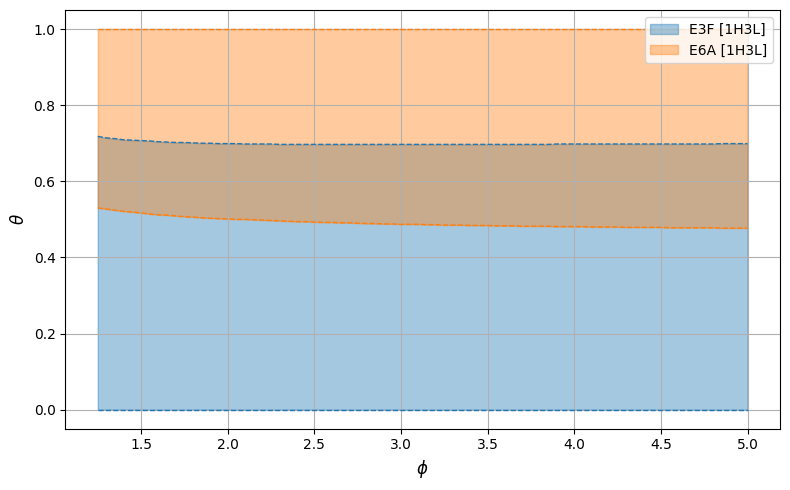

In [75]:
draw_grid_stability_plot(
    'Files/stability_domains_1H3L_combined_100_res.csv', 
    n = 4, n_h = 1, 
    nrow = 4, ncol=5, 
    gts=14,
    save_path1='Files/stability_grid_1H3L.png',
    save_path2='Files/stability_stable_1H3L.png'
    )

/var/folders/2_/37s1zdlx37z13rt227qsdtvr0000gp/T/ipykernel_10739/342908982.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_grid = cm.get_cmap('tab20', len(network_names))
/var/folders/2_/37s1zdlx37z13rt227qsdtvr0000gp/T/ipykernel_10739/342908982.py:83: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('tab10', max(10, len(stable_names)))


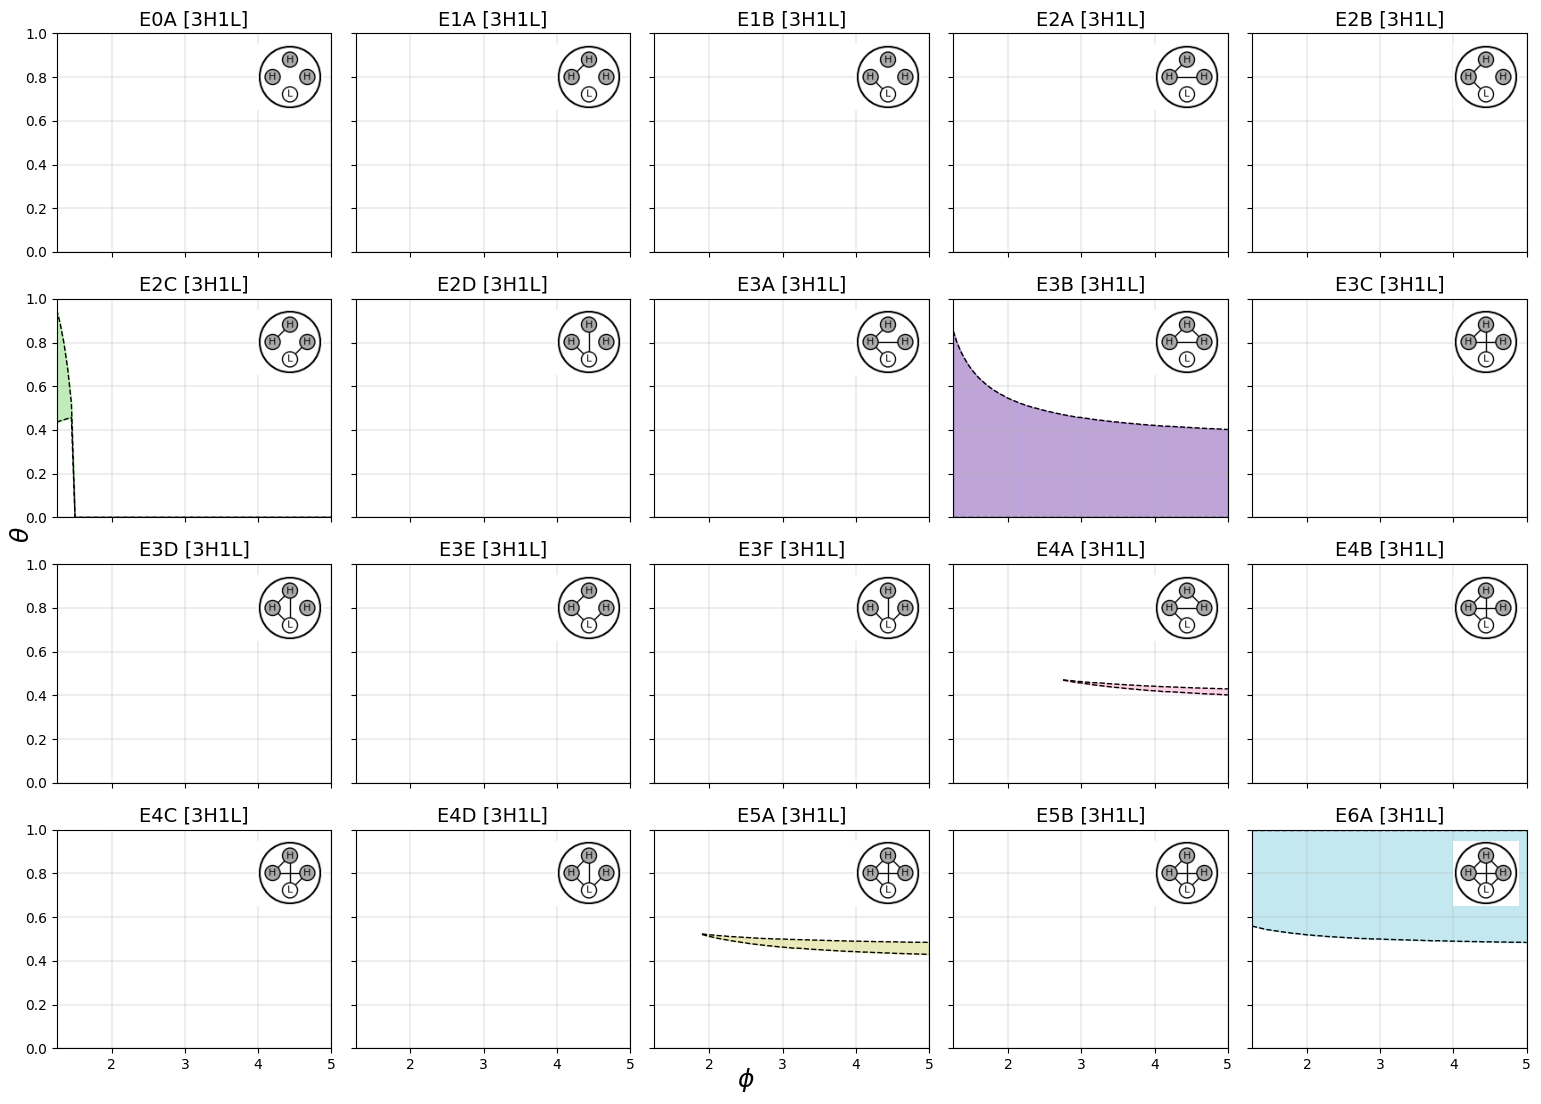

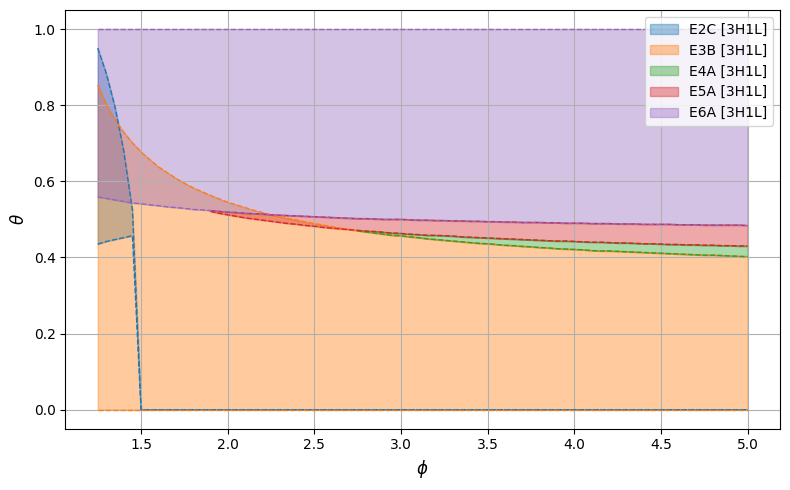

In [77]:
draw_grid_stability_plot(
    'Files/stability_domains_3H1L_combined_100_res.csv', 
    n = 4, n_h = 3, 
    nrow = 4, ncol=5, 
    gts=14,
    save_path1='Files/stability_grid_3H1L.png',
    save_path2='Files/stability_stable_3H1L.png'
    )

# Figure 2. Stability Domain only for Stable Structures

In [ ]:
def draw_grid_stability_plot_combined(
        file_path, n, n_h, nrow, ncol, save_path='', gts=12,
        linewidth=1.0,
        cmap_grid = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple'],
        name_to_label = {
            'E2E [2H2L]': 'Positive Assortative',
            'E4C [2H2L]': 'Intermediate',
            'E6A [2H2L]': 'Complete',
        }
    ):
    df = pd.read_csv(file_path)
    network_names = df["Network"].tolist()
    phi_cols = df.columns[1:]
    phi_values = [latex_to_float(col) for col in phi_cols]

    # Parse the stability domains
    all_parsed_domains = []
    for i in range(len(df)):
        raw_row = df.iloc[i, 1:]
        parsed = [parse_interval(str(entry)) for entry in raw_row]
        all_parsed_domains.append(parsed)

    # Generate graph mappings
    unique_graphs = generate_unique_graphs_with_names(n=n, n_h=n_h)
    name_to_graph = {g['name']: g['matrix'] for g in unique_graphs}
    name_to_image = {name: render_graph(mat, n_h=n_h) for name, mat in name_to_graph.items()}

    # Identify the stable networks (those with any non-zero domain)
    stable_names = []
    stable_domains = []
    for name, domains in zip(network_names, all_parsed_domains):
        if any(lb != 0.0 or ub != 0.0 for lb, ub in domains):
            stable_names.append(name)
            stable_domains.append(domains)

    # ------------------------------------------------
    # 🌟 Create a single figure with two subplots side-by-side
    # ------------------------------------------------
    fig, axs = plt.subplots(
        1, 2, # 1 row, 2 columns
        figsize=(16, 6)
    )

    # ------------------------------------------------
    # Plot 1 (Left): Combined Stability Plot (New Position: axs[0])
    # ------------------------------------------------
    ax_combined = axs[0]
    
    for idx, (name, domains) in enumerate(zip(stable_names, stable_domains)):
        color = cmap_grid[idx]
        phi_vals_filtered = []
        lowers_filtered = []
        uppers_filtered = []
        stability_started = False
        
        for phi, (lb, ub) in zip(phi_values, domains):
            if lb != 0.0 or ub != 0.0:
                stability_started = True
            if stability_started:
                phi_vals_filtered.append(phi)
                lowers_filtered.append(lb)
                uppers_filtered.append(ub)
                
        if phi_vals_filtered:
            ax_combined.fill_between(
                phi_vals_filtered, lowers_filtered, uppers_filtered, 
                alpha=0.4, 
                label=name_to_label.get(name, name), 
                color=color
            )
            
            # Plot the lines based on the original logic
            if name == 'E6A [2H2L]':
                ax_combined.plot(phi_vals_filtered, lowers_filtered, linestyle='--', color=color, linewidth=linewidth)
                ax_combined.plot(phi_vals_filtered, uppers_filtered, color=color, linewidth=linewidth)
            elif name == 'E2E [2H2L]':
                ax_combined.plot(phi_vals_filtered, lowers_filtered, color=color, linewidth=linewidth)
                ax_combined.plot(phi_vals_filtered, uppers_filtered, linestyle='--', color=color, linewidth=linewidth)
            else:
                ax_combined.plot(phi_vals_filtered, lowers_filtered, color=color, linewidth=linewidth, linestyle='--')
                ax_combined.plot(phi_vals_filtered, uppers_filtered, color=color, linewidth=linewidth, linestyle='--')

    ax_combined.set_title("Combined Stability Domains", fontsize=16)
    ax_combined.set_xlabel(r'$\phi$', fontsize=12)
    ax_combined.set_ylabel(r'$\theta$', fontsize=12)
    ax_combined.set_xlim(min(phi_values), max(phi_values))
    ax_combined.set_ylim(0, 1)
    ax_combined.grid(True)
    ax_combined.legend(loc='lower left', title="Network Type")


    # ------------------------------------------------
    # Plot 2 (Right): Grid Plot (New Position: axs[1] via GridSpec)
    # ------------------------------------------------
    
    # We create a nested Gridspec for the right subplot (axs[1])
    gs_right = GridSpec(
        nrow, 2 * ncol, 
        figure=fig, 
        width_ratios=[2, 1], 
        wspace=0.1, 
        hspace=0.3,
        left=0.57, right=0.95, top=0.9, bottom=0.15 # Adjusted position to the right
    )
    
    # Generate the actual axes for the grid plot
    grid_axs = []
    for i in range(nrow):
        for j in range(2 * ncol):
            grid_axs.append(fig.add_subplot(gs_right[i, j]))

    
    # Helper to map to correct indices based on original logic (assuming nrow=3, ncol=1 for a 3x2 grid)
    def map_index(i, j, n_cols=2*ncol):
        return i * n_cols + j
    
    
    for idx, (name, domains) in enumerate(zip(stable_names, stable_domains)):
        phi_vals_filtered = []
        lowers_filtered = []
        uppers_filtered = []
        stability_started = False

        for phi, (lb, ub) in zip(phi_values, domains):
            if lb != 0.0 or ub != 0.0:
                stability_started = True
            if stability_started:
                phi_vals_filtered.append(phi)
                lowers_filtered.append(lb)
                uppers_filtered.append(ub)
        
        # The original code had the plots in reverse order (2-idx)
        plot_row_idx = nrow - 1 - idx 

        # Left column: stability plot
        ax_plot = grid_axs[map_index(plot_row_idx, 0)]
        color = cmap_grid[idx]
        if phi_vals_filtered:
            ax_plot.fill_between(phi_vals_filtered, lowers_filtered, uppers_filtered, color=color, alpha=0.3)
            if name == 'E6A [2H2L]':
                ax_plot.plot(phi_vals_filtered, lowers_filtered, linestyle='--', linewidth=linewidth, color=color)
                ax_plot.plot(phi_vals_filtered, uppers_filtered, linewidth=linewidth, color=color)
            elif name == 'E2E [2H2L]':
                ax_plot.plot(phi_vals_filtered, lowers_filtered, linewidth=linewidth, color=color)
                ax_plot.plot(phi_vals_filtered, uppers_filtered, linestyle='--', linewidth=linewidth, color=color)
            else:
                ax_plot.plot(phi_vals_filtered, lowers_filtered, linewidth=linewidth, color=color, linestyle='--')
                ax_plot.plot(phi_vals_filtered, uppers_filtered, linewidth=linewidth, color=color, linestyle='--')
        
        ax_plot.set_title(name_to_label[name], fontsize=14)
        ax_plot.set_xlim(min(phi_values), max(phi_values))
        ax_plot.set_ylim(0, 1)
        ax_plot.set_ylabel(r'$\theta$')
        ax_plot.grid(True, linewidth=0.3)

        # Right column: inset graph image
        if name in name_to_image:
            ax_inset = grid_axs[map_index(plot_row_idx, 1)]
            ax_inset.imshow(name_to_image[name])
            ax_inset.axis("off")

        # Set X-label only for the bottom plot in the first column
        if plot_row_idx == nrow - 1:
            ax_plot.set_xlabel(r'$\phi$')
        else:
            ax_plot.tick_params(labelbottom=False)

    # Remove the placeholder axes for the nested grid.
    fig.delaxes(axs[1])

    # Final adjustments and saving
    # Use a generic tight_layout or adjust the GridSpec boundaries
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=500, bbox_inches='tight')
    else:
        plt.show()

/var/folders/2_/37s1zdlx37z13rt227qsdtvr0000gp/T/ipykernel_10739/3408533238.py:208: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


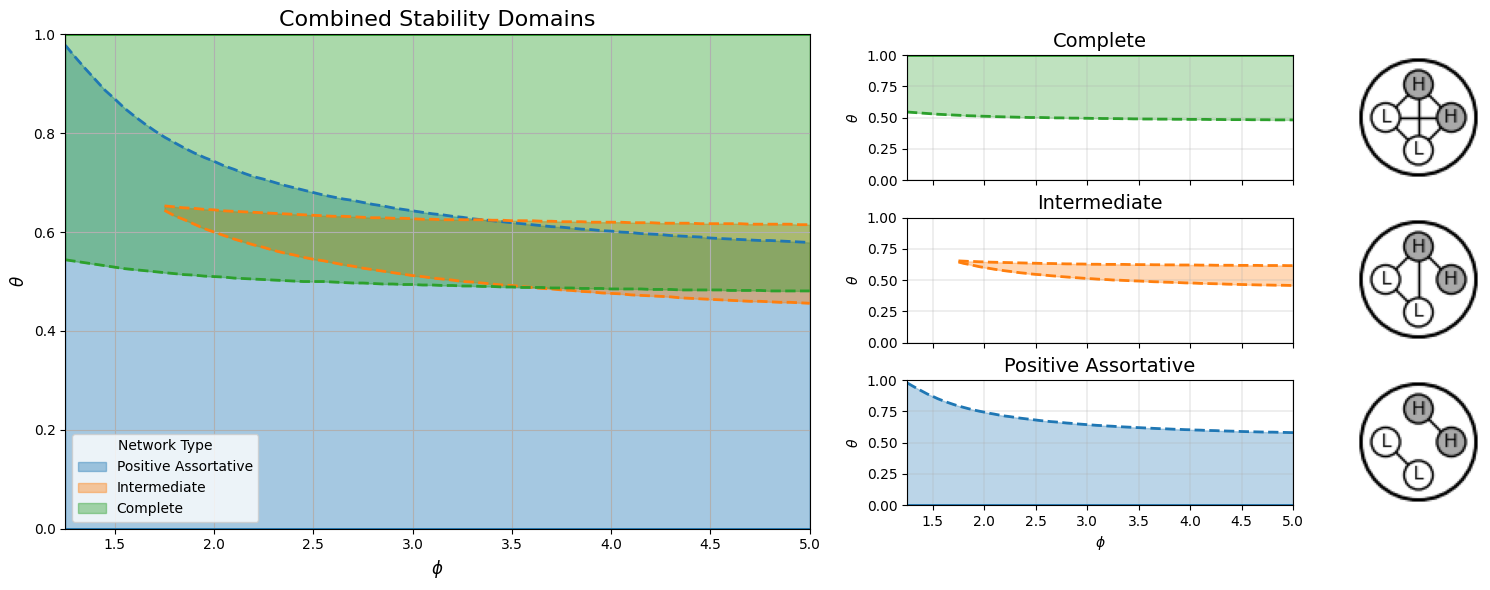

In [110]:
draw_grid_stability_plot_combined(
    'Files/stability_domains_2H2L_combined.csv', 
    n = 4, n_h = 2, 
    nrow = 3, ncol=1, 
    gts=14,
    save_path='Files/combined_stability_grid_2H2L.png',
    linewidth=2
    )
